#  Advanced Techniques for Applied Economics

### Group Members: Pan Yiming(NIS: 187922), Haori Wang(NIS: 201070)

# 1 In troduction
In this project, we want to use partial correlation network to estimate the covariance matrix. And then use the estimated covriance matrix to construct mean-variance portfolio.

We will use SP100 daily return data. And at the same time the we will use factor models to decompose the covariance matrix in the following way
$$\begin{aligned} r_{i, t} &=\alpha_{i}+\beta_{i}^{\prime} f_{t}+u_{i, t},(1) \\ \Sigma_{r, t} &=B^{\prime} \Sigma_{f, t} B+\Sigma_{u, t},(2) \end{aligned}$$

In this project, we will explore the following questions: 

1, the influence of the number of factors on the estimated network and correlation matrix. 


2, The out-of-sample performance of the estimated covriance matrix compared to sample covariance matrix. 

3, the dynamics of the network in crisis and post-crisis periods.


In [1]:
# import modules... which are quite a few!
from math import sqrt
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import igraph as ig
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression as linreg
from sklearn.covariance import GraphicalLasso as glasso
from sklearn.covariance import GraphicalLassoCV as glasso_cv
import warnings
warnings.filterwarnings("ignore")
sns.set(font_scale=0.5)

## 1.1 load stock price data

In [2]:
# read sp500 stock price dataset
sp500_returns = pd.read_csv("/Users/panyiming/Desktop/Mres/Research/network_portforlio/data/df_ret.csv",
                            parse_dates=True)

In [41]:
pf_rets = pd.read_csv('../../Research/network_portforlio/data/df_light_info.csv')
dates = pd.to_datetime(pf_rets["date"]) 

In [3]:
sp500_returns.head(10)

Unnamed: 0  Communication Services_OMC  Utilities_AEP  \
0        2779                   -3.345764       1.186000   
1        2780                   -2.910361       3.664115   
2        2781                    0.547858       0.566680   
3        2782                    4.147685       1.310165   
4        2783                    4.359785      -0.373045   
5        2784                   -2.220124       0.373045   
6        2785                   -0.321223       0.740347   
7        2786                   -0.128845      -0.184973   
8        2787                   -1.166465       0.000000   
9        2788                   -2.441542      -2.432219   

   Consumer Defensive_UL  Utilities_SJI  Energy_CVX  Technology_AKAM  \
0              -1.466551       0.440055    0.000000        -6.843716   
1               4.133309       0.874343    1.777474        -5.657035   
2               2.004305       0.431158    4.170191       -18.285080   
3               5.406404       0.863052    1.745430         5.057838   
4              -3.637316      -0.213494   -2.735830        13.930233   
5              -0.978960       0.642243   -0.929006        -2.504841   
6               0.392735      -0.642243   -0.359621        -9.185935   
7              -0.589682       0.642243    0.932337        -8.710086   
8               0.393508       0.000000   -0.644537        -1.215410   
9              -4.624124      -0.859344    2.623096        -8.385431   

   Industrials_URI  Communication Services_NYT  Real Estate_MAC  ...  \
0        -1.129956                   -4.256177        -1.863244  ...   
1        -0.379507                   -1.920433         1.554823  ...   
2         5.546708                   -0.974078         1.836418  ...   
3         3.186110                    2.349776         3.863668  ...   
4        -0.699304                    4.931052         2.589045  ...   
5         0.000000                   -2.902636         1.130881  ...   
6         0.000000                   -0.402462         1.394336  ...   
7         4.124296                    3.044651         1.375161  ...   
8         1.005034                   -2.374778         0.000000  ...   
9         1.324523                   -2.706553         0.273075  ...   

   Financial Services_HSBC  Consumer Defensive_FMX  Consumer Cyclical_KMX  \
0                -6.294941               -8.908063              -2.812516   
1                -0.566603                2.150511              -2.903325   
2                -2.882197                0.000000               5.715841   
3                 2.787377                6.329647               5.406722   
4                 0.094820                6.222333               2.601651   
5                -5.248840               -3.965371              -5.264152   
6                 1.190550               -1.403915              -5.556738   
7                 1.370995                4.696630              -8.965787   
8                -0.585398                3.449074               0.000000   
9                -1.082136               -0.786052               0.000000   

   Industrials_CNR  Financial Services_TFC  Energy_CNX  Industrials_KAI  \
0        -3.109468               -2.949102   -1.861933         0.000000   
1        -4.668523                1.239006    1.242668         0.000000   
2        -1.109395                4.573856    4.231616         0.000000   
3         3.650582                0.703307    2.920017        -3.540168   
4        -1.081932               -2.603339    0.583492         0.897099   
5        -1.459255               -2.673824   -1.156560         0.000000   
6        -0.737691                3.224224    1.712847         0.000000   
7         0.000000                7.855816    4.982197         0.888807   
8         0.737691                3.708368   -0.538945        -0.888807   
9        -1.481945               -4.601328    1.621011         0.888807   

   Energy_RIG  Communication Services_USM  Technology_IBM  
0   -5.884672         

In [4]:
sp500_returns.drop('Unnamed: 0', axis=1)
cols_sp100 = sorted(list(sp500_returns.columns)[1:101])
sp100 = sp500_returns[cols_sp100]
# number of companies
N = len(sp100.columns)

In [5]:
sectors_ls = ['Materials', 'Communication Services', 'Consumer Cyclical', 
              'Consumer Defensive', 'Energy', 'Financial Services', 'Healthcare',
              'Industrials', 'Real Estate', 'Technology', 'Utilities']
color_dict = {"Materials": "grey", 
              "Consumer Staples": "lightgrey", 
              "Energy": "red", 
              "Financials": "yellow", 
              "Health Care": "pink",
              "Industrials": "purple", 
              "Information Technology": "green",
              "Materials": "brown", 
              "Telecommunications Services":"lightgreen", 
              "Utilities": "orange"}

In [6]:
sp100.head(10)

Basic Materials_CX  Basic Materials_EMN  Basic Materials_FUL  \
0           -7.830245            -2.452708            -3.019594   
1           -0.746253             4.846695             0.173793   
2           -0.750176             6.116127            -0.928720   
3            1.743948            -0.247376             4.779154   
4            2.189162            -3.146602             0.221888   
5           -2.686481            -1.157692            -0.444269   
6           -0.744767             3.182665             2.257717   
7            1.242086            -1.133541             3.266771   
8            2.432349            -1.662011             5.533762   
9            0.000000            -2.478260            -0.199521   

   Basic Materials_MT  Basic Materials_NEM  Basic Materials_NEU  \
0            3.891749            -7.831215             0.000000   
1            1.890078             1.117323             0.000000   
2            3.315571            -1.117323            -1.652711   
3            3.907768            -3.720005             1.652711   
4           -0.348897            -0.291969             1.625840   
5           -2.120171             5.683313             1.600577   
6            0.356360            -2.234716            -1.600577   
7            2.112709            -3.448596             1.600577   
8            1.727254            -2.666808            -3.226418   
9           -8.576480             6.115404             1.625840   

   Basic Materials_SCCO  Basic Materials_SSRM  Basic Materials_X  \
0             -0.818968             -2.535964          -3.804265   
1             -0.837409             -8.000088           1.015216   
2              0.837409              0.000000           0.604387   
3              1.231670              5.406722           2.576647   
4              1.633986              0.000000          -0.785926   
5             -2.461102             -5.406722          -1.590208   
6              0.000000             10.536052          -3.259219   
7              0.827116              7.228272           4.256215   
8              3.639624             -2.349256          -2.004031   
9             -3.639624              0.000000          -6.913771   

   Communication Services_BCE  ...  Technology_NSIT  Technology_SMTC  \
0                   -5.329487  ...        -5.977311        -8.701138   
1                   -3.793549  ...         0.722169         4.445176   
2                   -5.292864  ...        -0.722169        -3.611152   
3                   10.102699  ...         0.722169         4.295305   
4                    2.638598  ...         0.627379         6.169357   
5                   -1.775407  ...        -2.625920        -2.762246   
6                   -3.202705  ...        -1.851608        -2.953596   
7                    1.103622  ...         2.400558        -0.681047   
8                   -0.956106  ...         2.166153        19.589643   
9                    5.181925  ...        -5.505986        -2.945427   

   Utilities_AEP  Utilities_D  Utilities_EIX  Utilities_ES  Utilities_EXC  \
0       1.186000     2.428958       0.992250      0.000000      -0.740556   
1       3.664115     2.683577       6.222316      0.601872       4.719294   
2       0.566680     1.084550      -0.232214      1.193943       0.176653   
3       1.310165     0.000000       4.100881      0.886432       0.000000   
4      -0.373045     0.000000       0.000000     -0.886432       5.843030   
5       0.373045     0.307897      -0.447966     -0.296911      -0.669857   
6       0.740347     0.765017       0.224574      0.593901       0.837894   
7      -0.184973     1.211744      -0.673872     -0.891696       2.955963   
8       0.000000     0.300952      -0.904697     -1.504387      -0.324892   
9      -2.432219    -0.149768      -1.835029     -2.453904      -2.133708   

   Utilities_NEE  Utilities_PEG  Utilities_SJI  
0       1.801851       0.731394       0.440055  
1       3.220729       2.517124       0

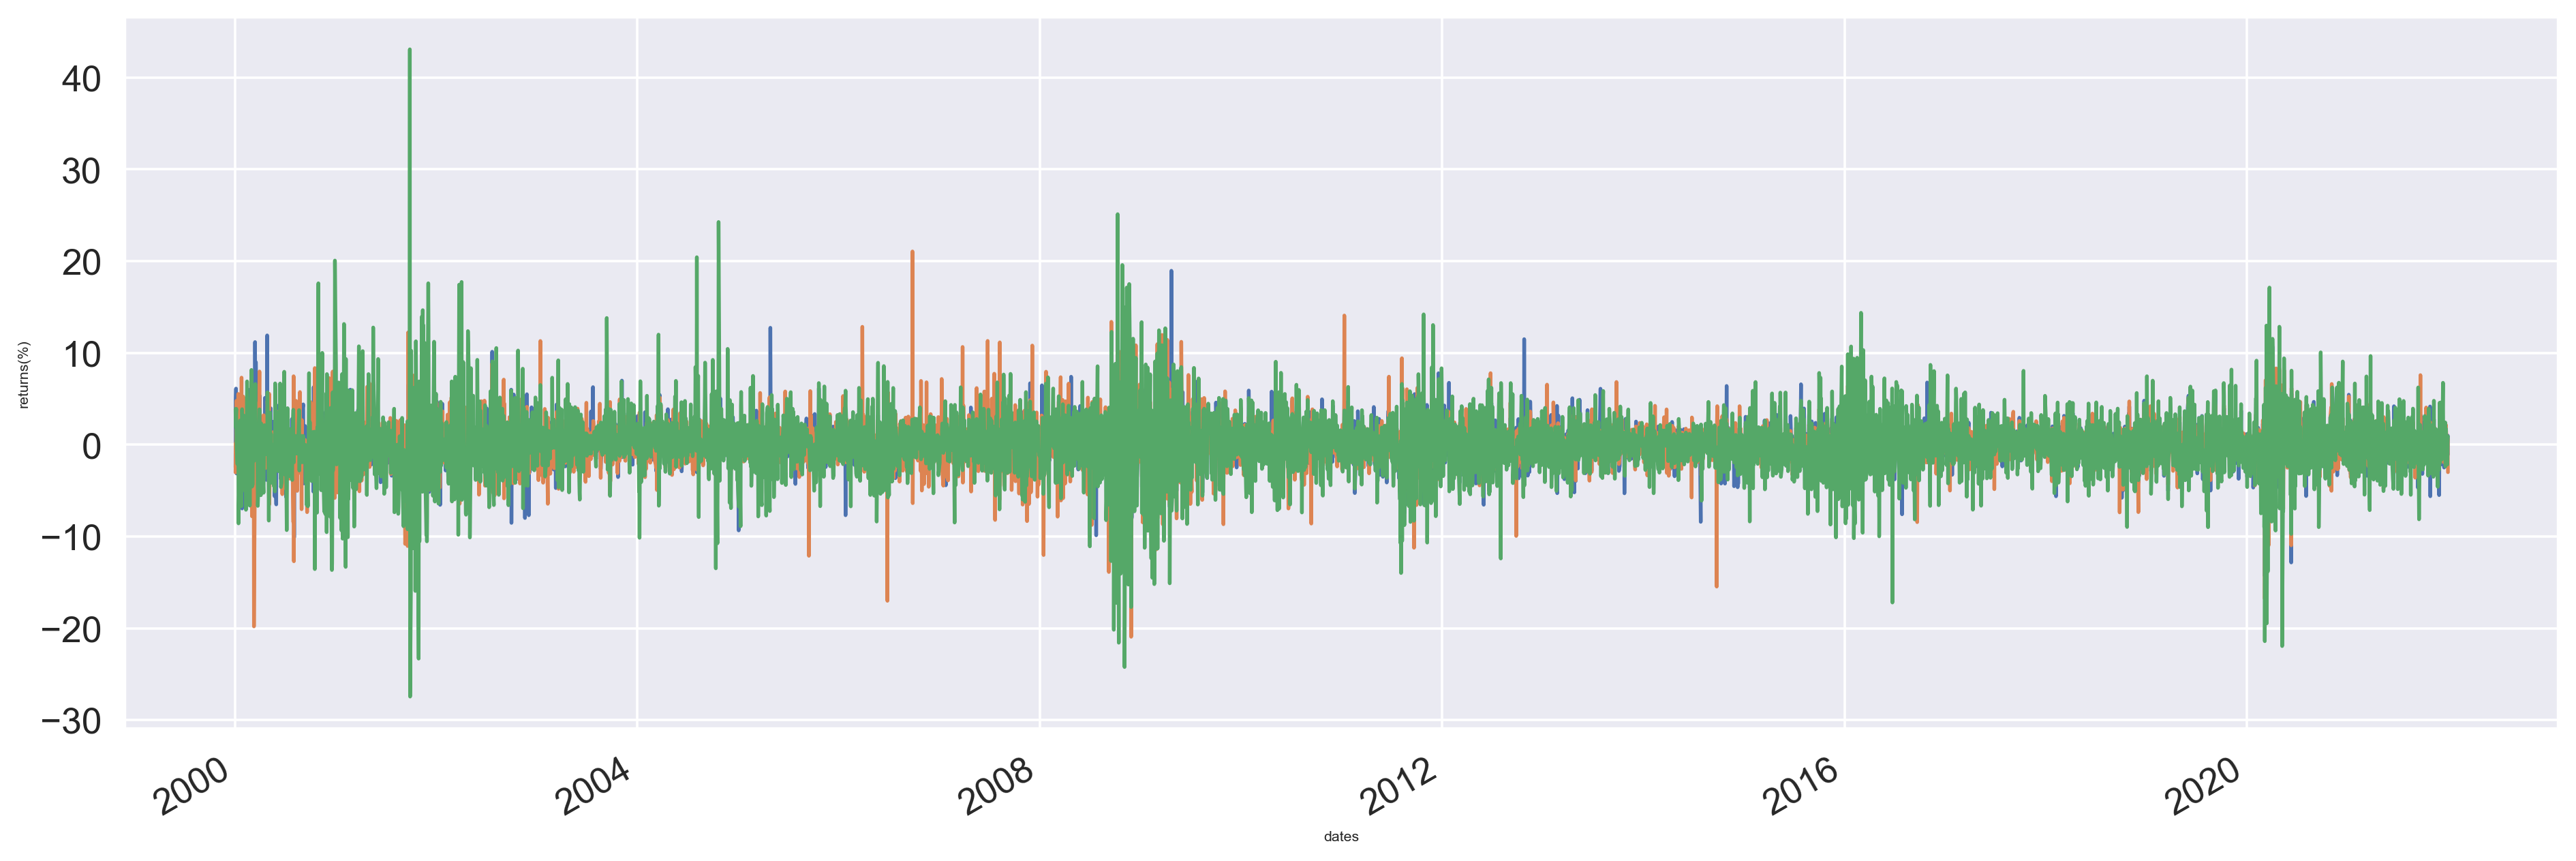

In [47]:
# plot all returns series
sp100_date = sp100.copy()
sp100_date['date'] = dates
plt.rcParams["figure.dpi"] = 256
sp100_date.plot('date', [1,2,3], figsize=(18, 6),legend=False)

#plt.plot(dates, sp100.to_numpy(), color='pink',  label='SP500', linewidth=0.5)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('dates')
plt.ylabel('returns(%)')
plt.show()

## 1.2 load Fama-French Dataset

In [72]:
df_factors = pd.read_csv('/Users/panyiming/Desktop/Mres/Research/network_portforlio/data/FF5_daily.csv',
                         parse_dates=True)
df_factors = df_factors[(df_factors['Date']>=20000101) & ((df_factors['Date']<=20211231))]
df_factors = df_factors.drop('Date', axis=1)
df_factors_date = df_factors.copy()
df_factors_date = df_factors_date.reset_index(drop=True)
df_factors_date['date'] = dates
df_factors.head(10)

Mkt-RF   SMB   HML   RMW   CMA     RF
9192   -0.71 -0.06 -1.42 -1.50 -0.63  0.021
9193   -4.06  0.33  2.07  0.47  1.45  0.021
9194   -0.09  0.33  0.16  0.41  1.11  0.021
9195   -0.73 -0.05  1.26  0.65  1.22  0.021
9196    3.21 -0.94 -1.43 -0.88 -0.95  0.021
9197    1.76  0.50 -1.52 -1.97 -0.24  0.021
9198   -1.71  0.35  0.81  0.81  1.08  0.021
9199   -0.69 -0.23  0.78  0.42  0.96  0.021
9200    1.59  0.49 -0.91 -1.77 -1.05  0.021
9201    1.15  0.27 -0.65 -0.31 -0.64  0.021

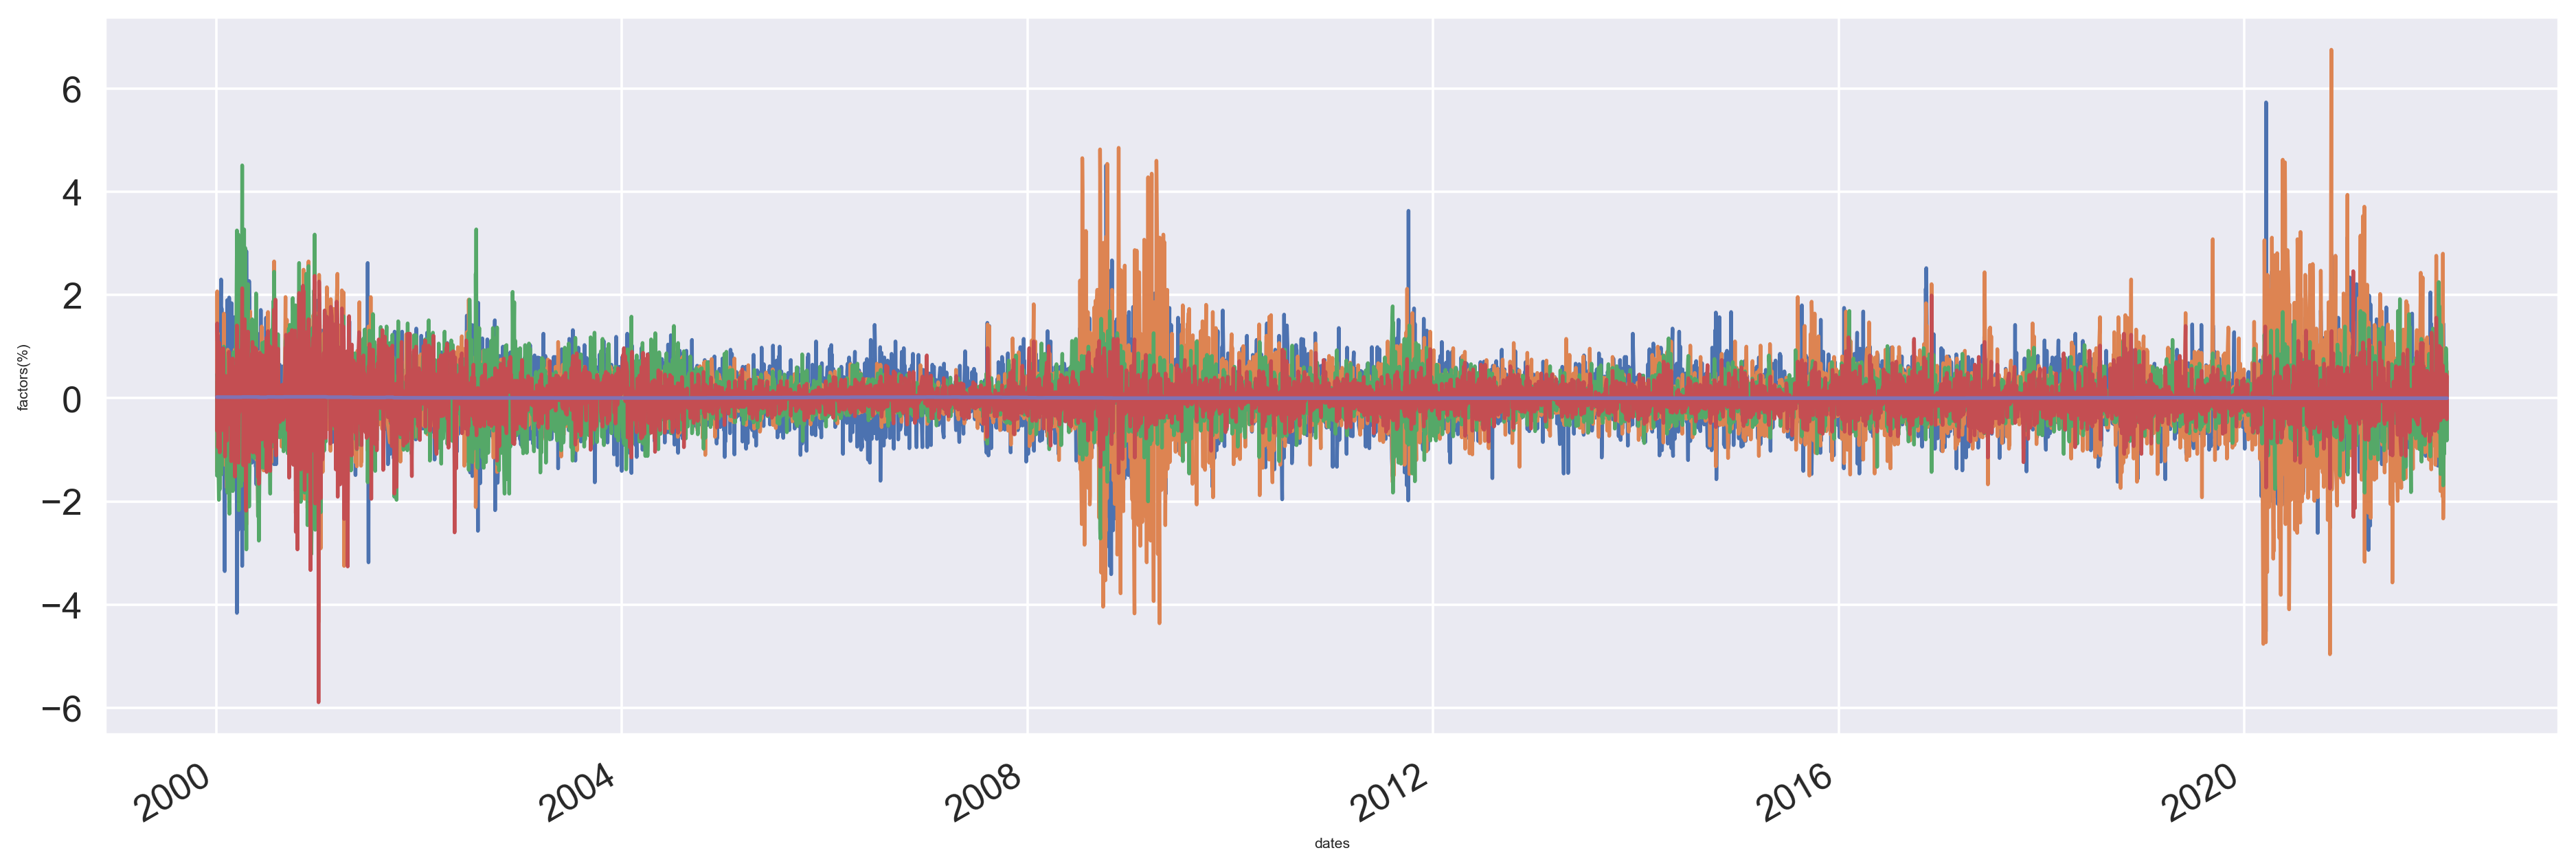

In [74]:
# plot all factors series
plt.rcParams["figure.dpi"] = 256
df_factors_date.plot('date', [1,2,3,4,5], figsize=(18, 6),legend=False)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('dates')
plt.ylabel('factors(%)')
plt.show()

##   1.3 Stock Returns Descriptive stats

In [10]:
sp100.describe(include='all')

Basic Materials_CX  Basic Materials_EMN  Basic Materials_FUL  \
count         5536.000000          5536.000000          5536.000000   
mean             0.000488             0.042022             0.036707   
std              2.897352             2.063532             2.396144   
min            -24.264135           -14.622808           -20.929130   
25%             -1.377261            -0.962431            -1.086164   
50%              0.000000             0.035247             0.038495   
75%              1.370888             1.020731             1.143847   
max             25.978817            18.954819            21.058429   

       Basic Materials_MT  Basic Materials_NEM  Basic Materials_NEU  \
count         5536.000000          5536.000000          5536.000000   
mean             0.006843             0.022127             0.059070   
std              3.552738             2.493729             2.897912   
min            -27.445926           -15.189839           -29.849045   
25%             -1.720334            -1.301172            -1.031134   
50%              0.000000             0.000000             0.000000   
75%              1.686009             1.345715             1.164726   
max             43.080749            22.453310            24.995601   

       Basic Materials_SCCO  Basic Materials_SSRM  Basic Materials_X  \
count           5536.000000           5536.000000        5536.000000   
mean               0.076612              0.047541          -0.000343   
std                2.630649              3.739935           3.570506   
min              -22.557112            -28.599857         -31.164568   
25%               -1.249133             -2.011965          -1.863629   
50%                0.073893              0.000000           0.000000   
75%                1.443142              2.128600           1.883305   
max               25.571433             27.652747          21.868123   

       Communication Services_BCE  ...  Technology_NSIT  Technology_SMTC  \
count                 5536.000000  ...      5536.000000      5536.000000   
mean                     0.037869  ...         0.026815         0.020767   
std                      1.606451  ...         3.480575         3.091672   
min                    -41.622700  ...       -65.981076       -29.759717   
25%                     -0.574234  ...        -1.247752        -1.411301   
50%                      0.068441  ...         0.054630         0.000000   
75%                      0.688020  ...         1.325897         1.449041   
max                     18.345594  ...        27.625034        20.205728   

       Utilities_AEP  Utilities_D  Utilities_EIX  Utilities_ES  Utilities_EXC  \
count    5536.000000  5536.000000    5536.000000   5536.000000    5536.000000   
mean        0.036350     0.041729       0.029303      0.038947       0.036453   
std         1.564814     1.405041       2.184809      1.417006       1.668142   
min       -25.857693   -13.681766     -42.665397    -13.720042     -17.541301   
25%        -0.649395    -0.588677      -0.773099     -0.612301      -0.750425   
50%         0.087213     0.054608       0.070509      0.059919       0.081094   
75%         0.771226     0.755273       0.923874      0.746249       0.867108   
max        18.099973    15.898830      30.255713     13.802144      16.546193   

       Utilities_NEE  Utilities_PEG  Utilities_SJI  
count    5536.000000    5536.000000    5536.000000  
mean        0.064944       0.041066       0.038416  
std         1.456842       1.578698       1.552465  
min       -14.406755     -11.865414     -21.223939  
25%        -0.603230      -0.696272      -0.664127  
50%         0.096841       0.075451       0.053982  
75%         0.747687       0.854012       0.790618  
max        13.052247      15.808694      17.782072  

[8 rows x 100 columns]

 # 2 The Five factors effect

## 2.1 sample correlatin of raw return data 

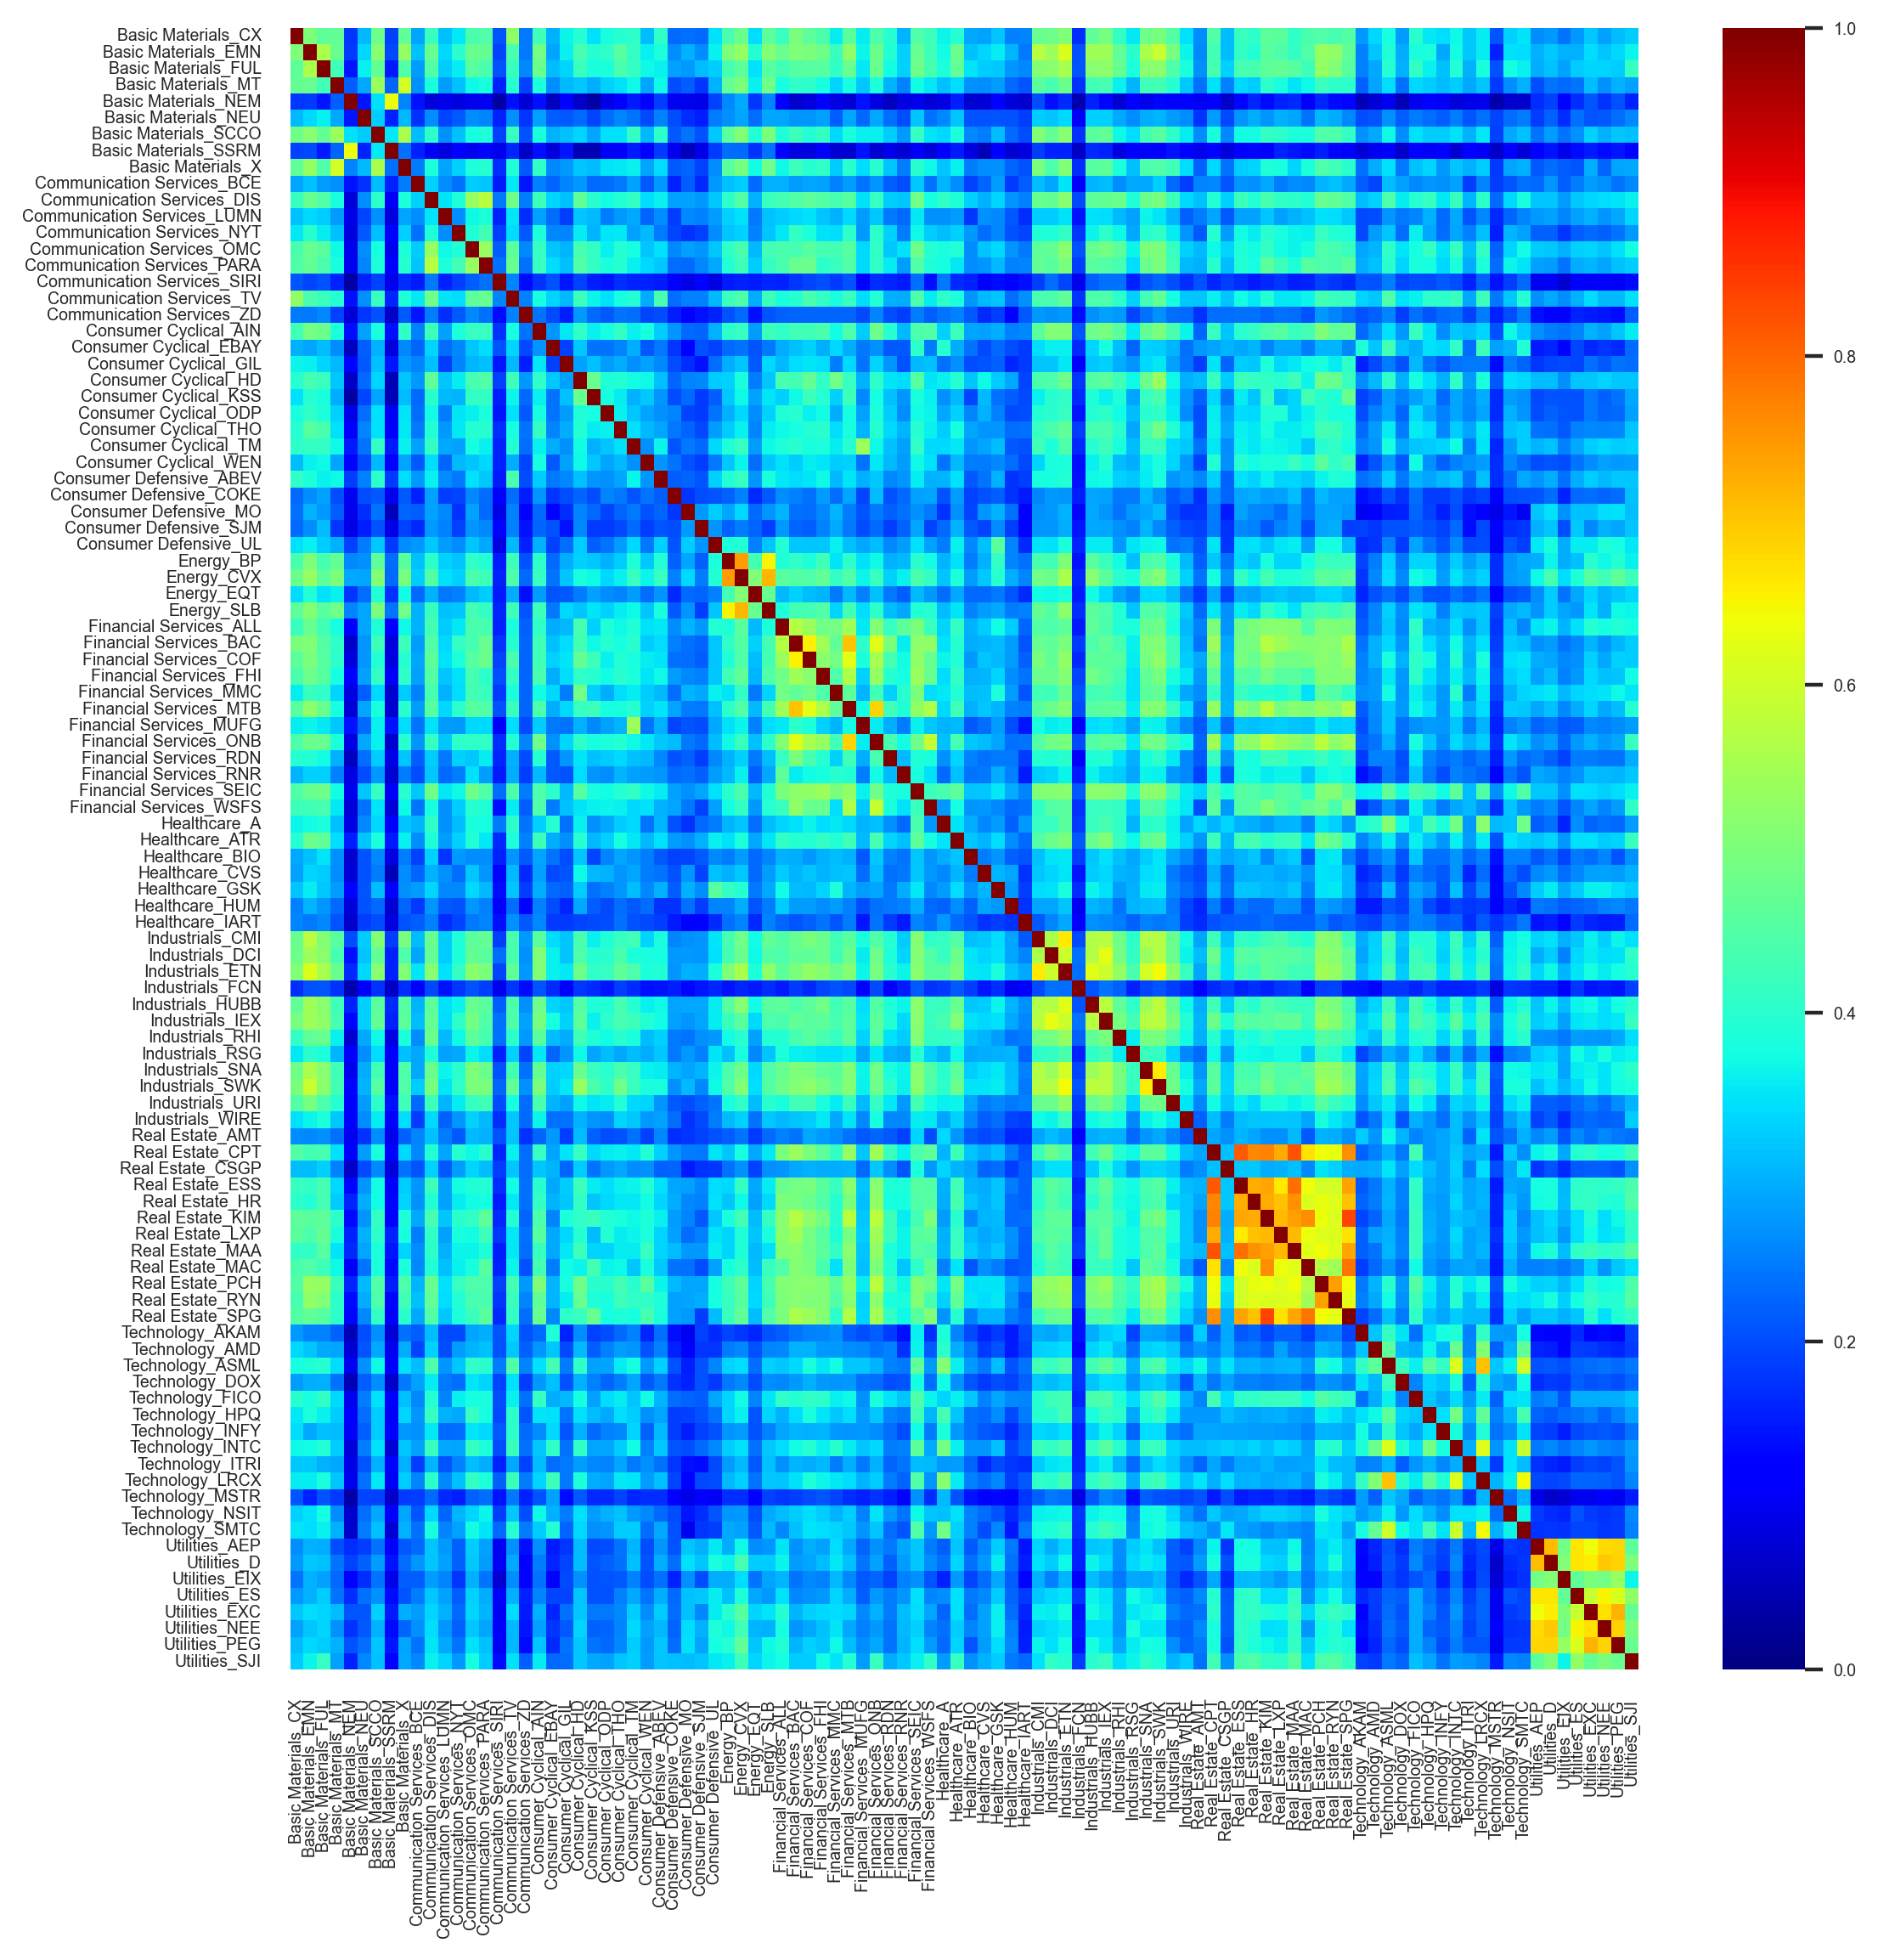

In [11]:
# plot the heatmap of the correlation matrix of the returns
corr = sp100.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr,  xticklabels=sp100.columns, vmin=0, vmax=1,
            yticklabels=sp100.columns, cmap='jet')
plt.show()

## 2.2 get residuals from Fama-French five factors model

In [12]:
# create the panel of idiosyncratic returns from Fama-French factors
sp100_idio = pd.DataFrame(columns=sp100.columns,index=sp100.index)
market_factor = df_factors[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
betas = np.zeros( (N) )
x = market_factor.values
x = x.reshape(len(x), 5)
for i in range(N):
    y = sp100[ sp100.columns[i] ].values
    y = y.reshape(len(y), 1)
    reg = linreg().fit( x , y  )
    sp100_idio[ sp100_idio.columns[i] ] =  y - reg.predict(x)
    betas[i] = abs(reg.coef_[0][0])

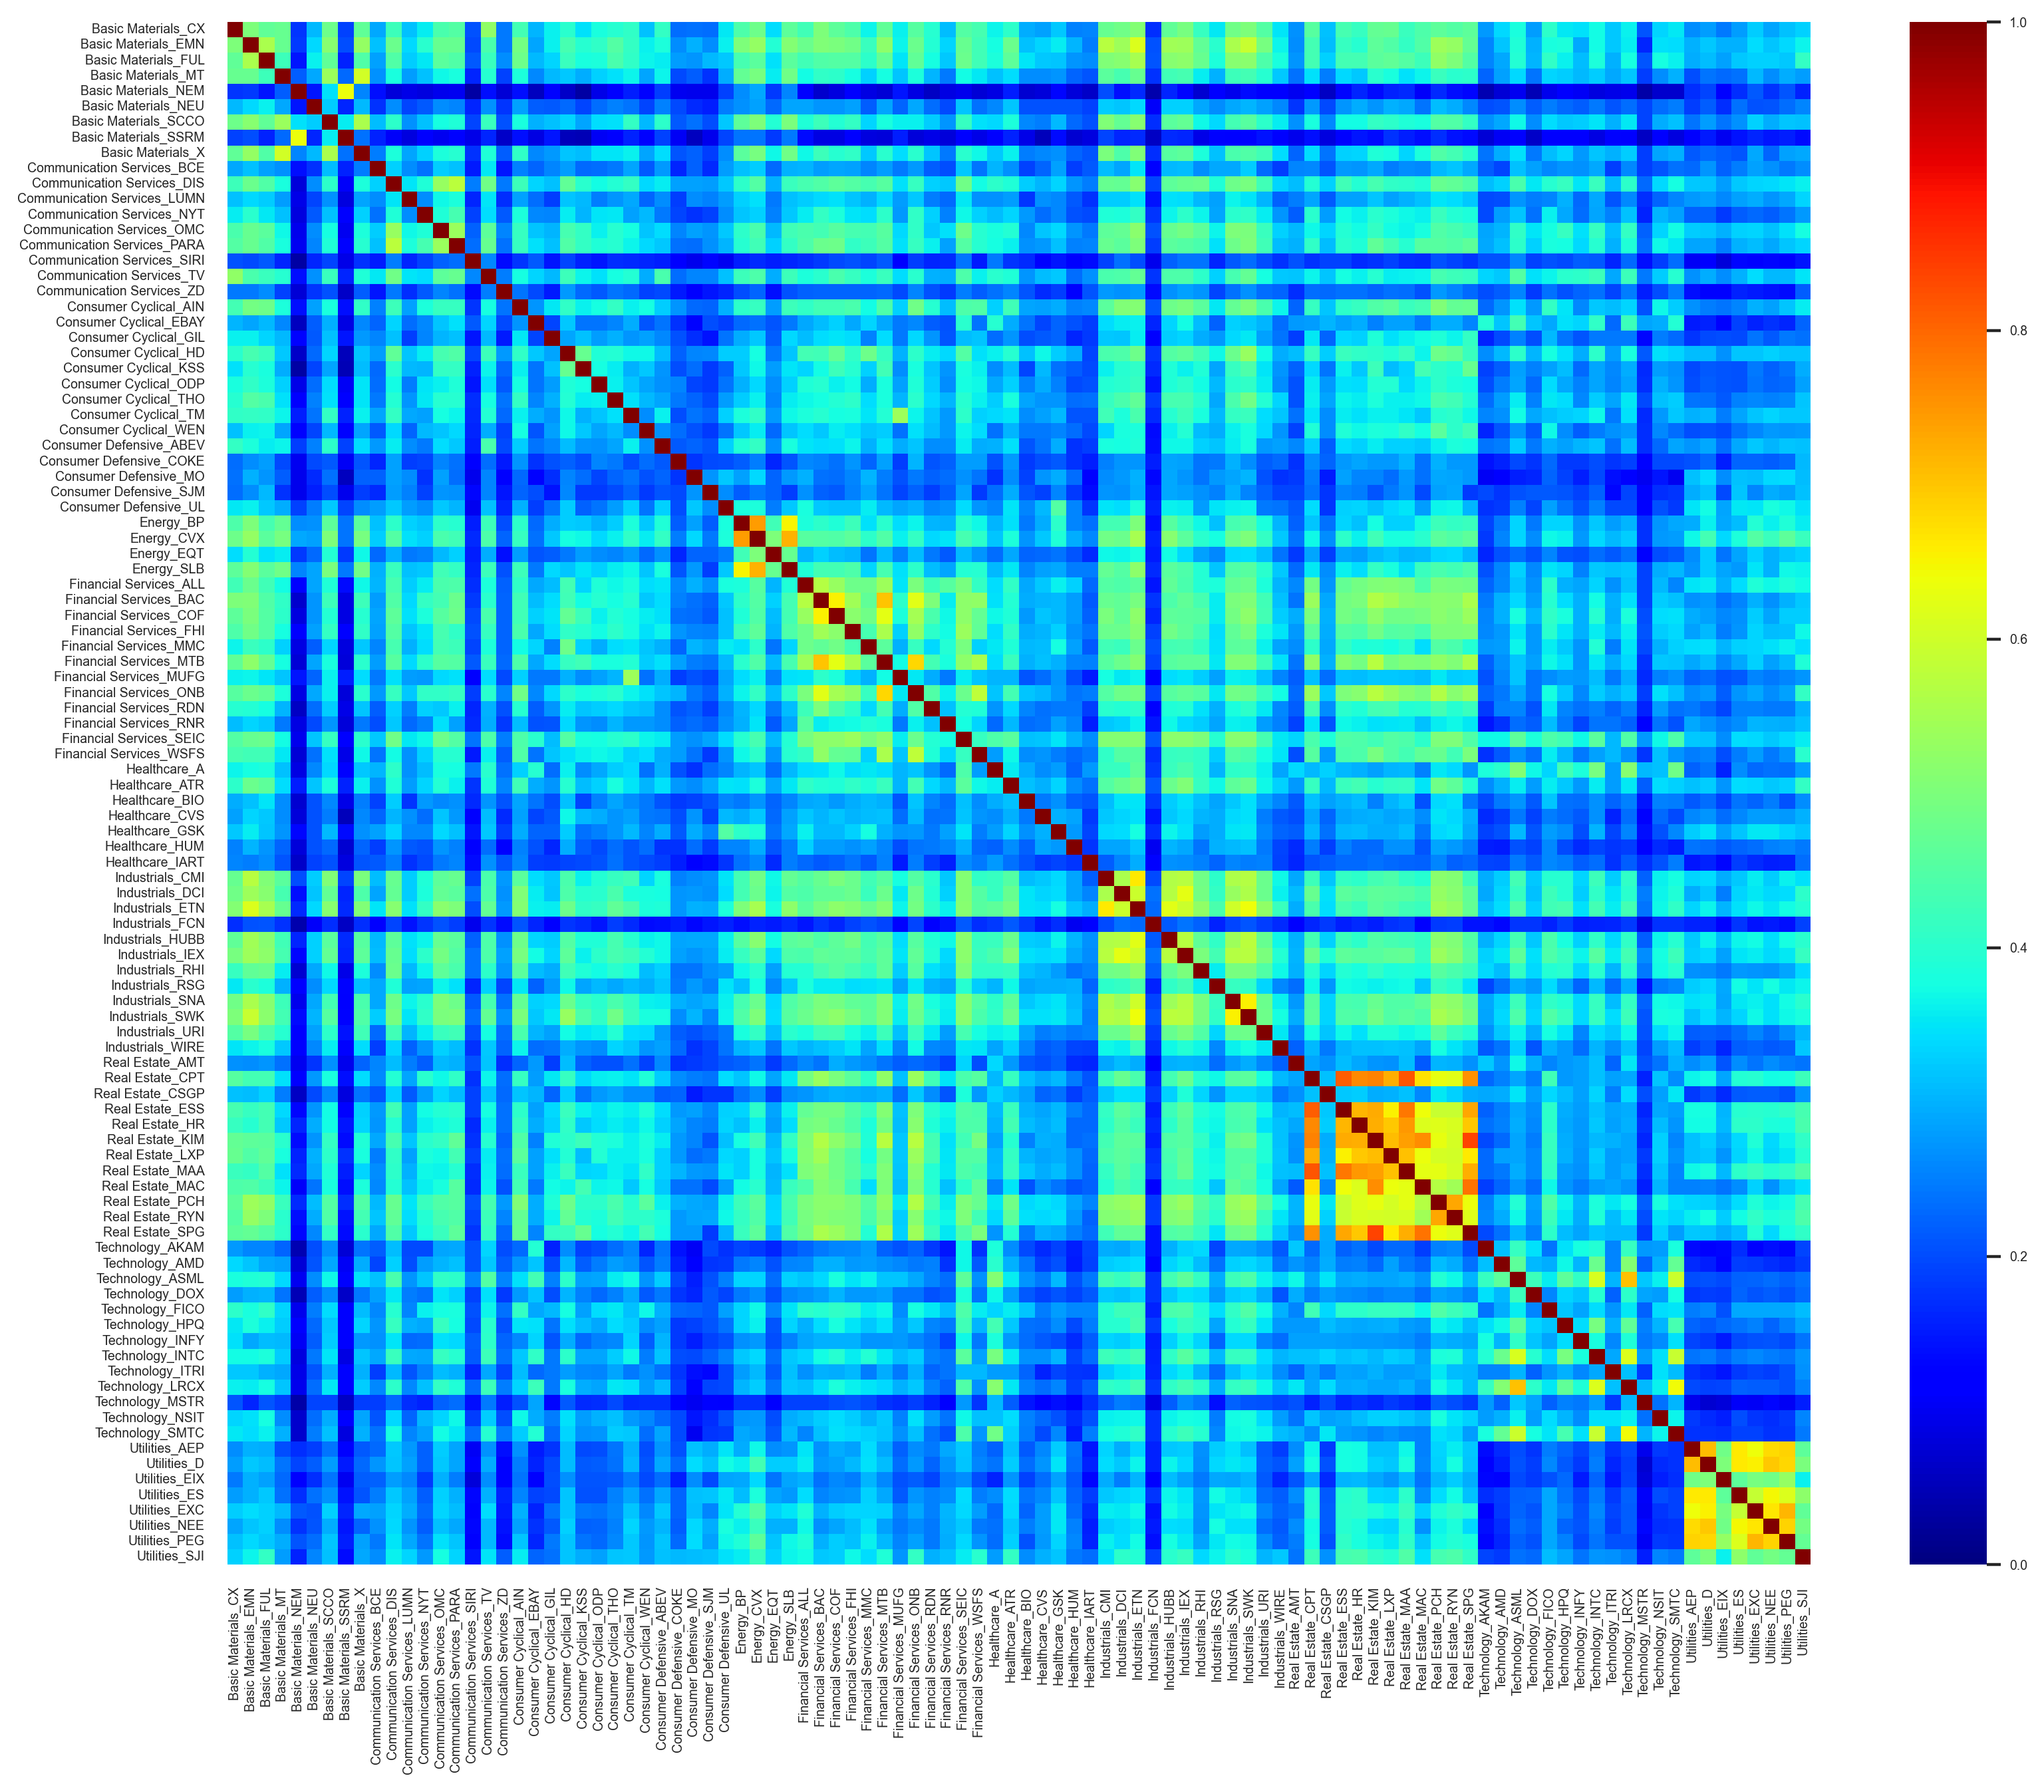

In [13]:
# heatmap of the idiosyncratic correlation 
corr1 = sp100_idio.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr1, xticklabels=sp100_idio.columns,  vmin=0, vmax=1,
            yticklabels=sp100_idio.columns, cmap='jet')
plt.show()

## 2.3 estimate graphic from residuals

In [14]:
# we are going to use the GraphicalLasso routine from the sklearn package
# the function requires as imputs alpha=the lasso tuning parameter and 
sp100_network = glasso(alpha=0.1).fit(sp100_idio)

In [15]:
# compute a number of outputs associatd with the Glasso
# get the precision matrix
K = sp100_network.precision_
# construct the adjencency matrix
A = np.zeros((N, N))
for i in range(N):
    for j in range(i-1):
        if abs(K[i,j]) > 0:
            A[i,j] = 1
            A[j,i] = 1

# construct partial correlations            
PC = np.zeros( (N, N) )
for i in range(N):
    for j in range(i-1):
        if abs(K[i,j]) > 0:
            PC[i,j] = -K[i,j]/sqrt(K[i,i] * K[j,j])

# compute the degree
degree = A.sum(axis = 0) 
print('Number of connections %d '% (sum(degree)/2))
print("Network density %2.2f%%" % ( 100*(sum(degree)/2) / (N*(N-1)/2))) 

Number of connections 1987 
Network density 40.14%


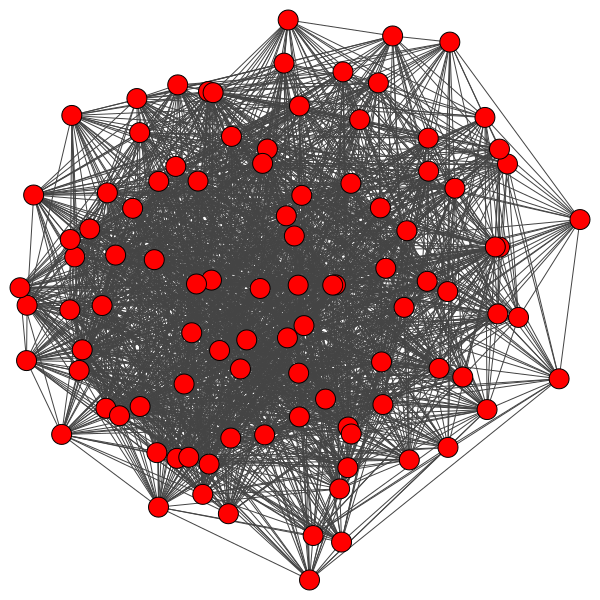

In [16]:
# create a graph object
g = ig.Graph.Adjacency((A>0).tolist() , mode=ig.ADJ_UNDIRECTED )
ig.plot(g)

## 2.4 conclusion for Five facotr model:

After regressing the return on the five factors, we got the residual parts. But the residual parts are still highly correlated with each other. Seeing from the correlation matrix, there is no sparsity. And the Network density dose not change too much. So we will use PAC to estmate the residual parts.

# 4 PCA

## 4.1 PCA factors

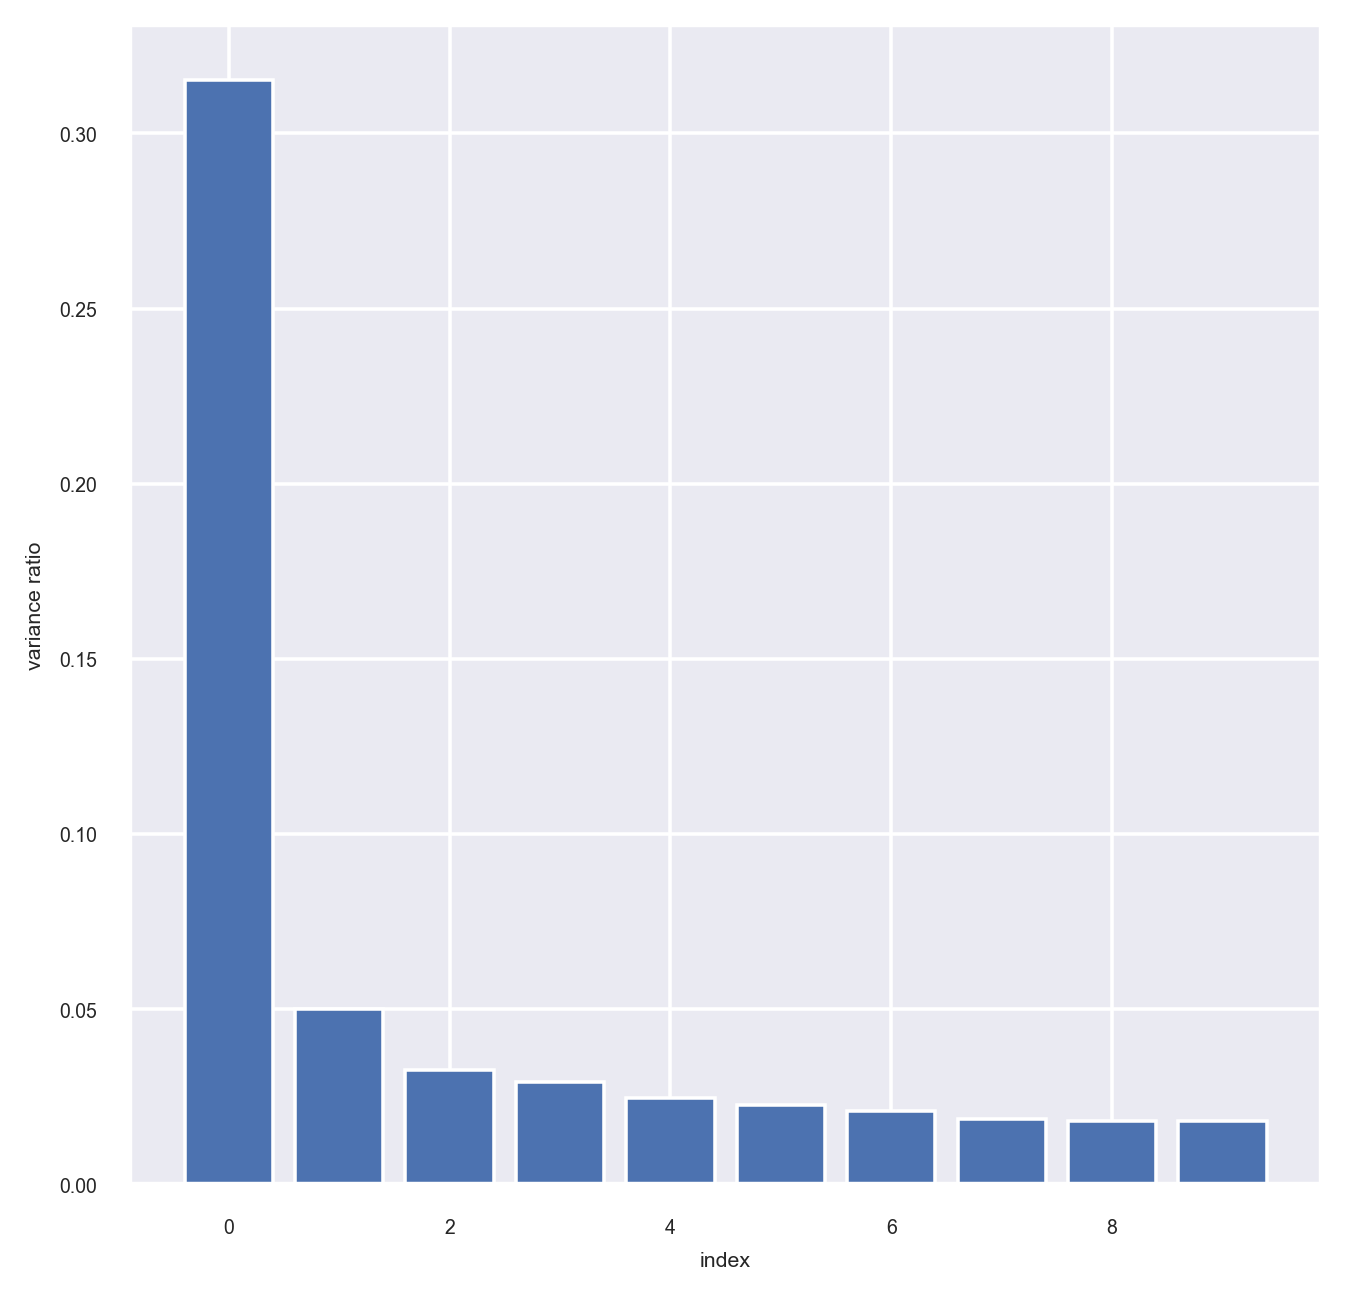

pca1      pca2      pca3      pca4      pca5
0 -7.830245 -2.452708 -3.019594  3.891749 -7.831215
1 -0.746253  4.846695  0.173793  1.890078  1.117323
2 -0.750176  6.116127 -0.928720  3.315571 -1.117323
3  1.743948 -0.247376  4.779154  3.907768 -3.720005
4  2.189162 -3.146602  0.221888 -0.348897 -0.291969
5 -2.686481 -1.157692 -0.444269 -2.120171  5.683313
6 -0.744767  3.182665  2.257717  0.356360 -2.234716
7  1.242086 -1.133541  3.266771  2.112709 -3.448596
8  2.432349 -1.662011  5.533762  1.727254 -2.666808
9  0.000000 -2.478260 -0.199521 -8.576480  6.115404

In [17]:
# the first principle component accouts for over 30% variance in the return dataset.
import numpy as np
from sklearn.decomposition import PCA
X = sp100.to_numpy()
pca = PCA(n_components=10)
pca.fit(X)
#print(pca.explained_variance_ratio_)
lx = [i for i in range(10)]
plt.figure(figsize=(6, 6))
plt.rcParams["figure.dpi"] = 128
plt.bar(lx,  pca.explained_variance_ratio_, width=0.8)
plt.xlabel('index')
plt.ylabel('variance ratio')
plt.show()
df_pca_factors = pd.DataFrame(X[:, 0:5], columns=['pca1', 'pca2','pca3','pca4','pca5'])
df_pca_factors.head(10)

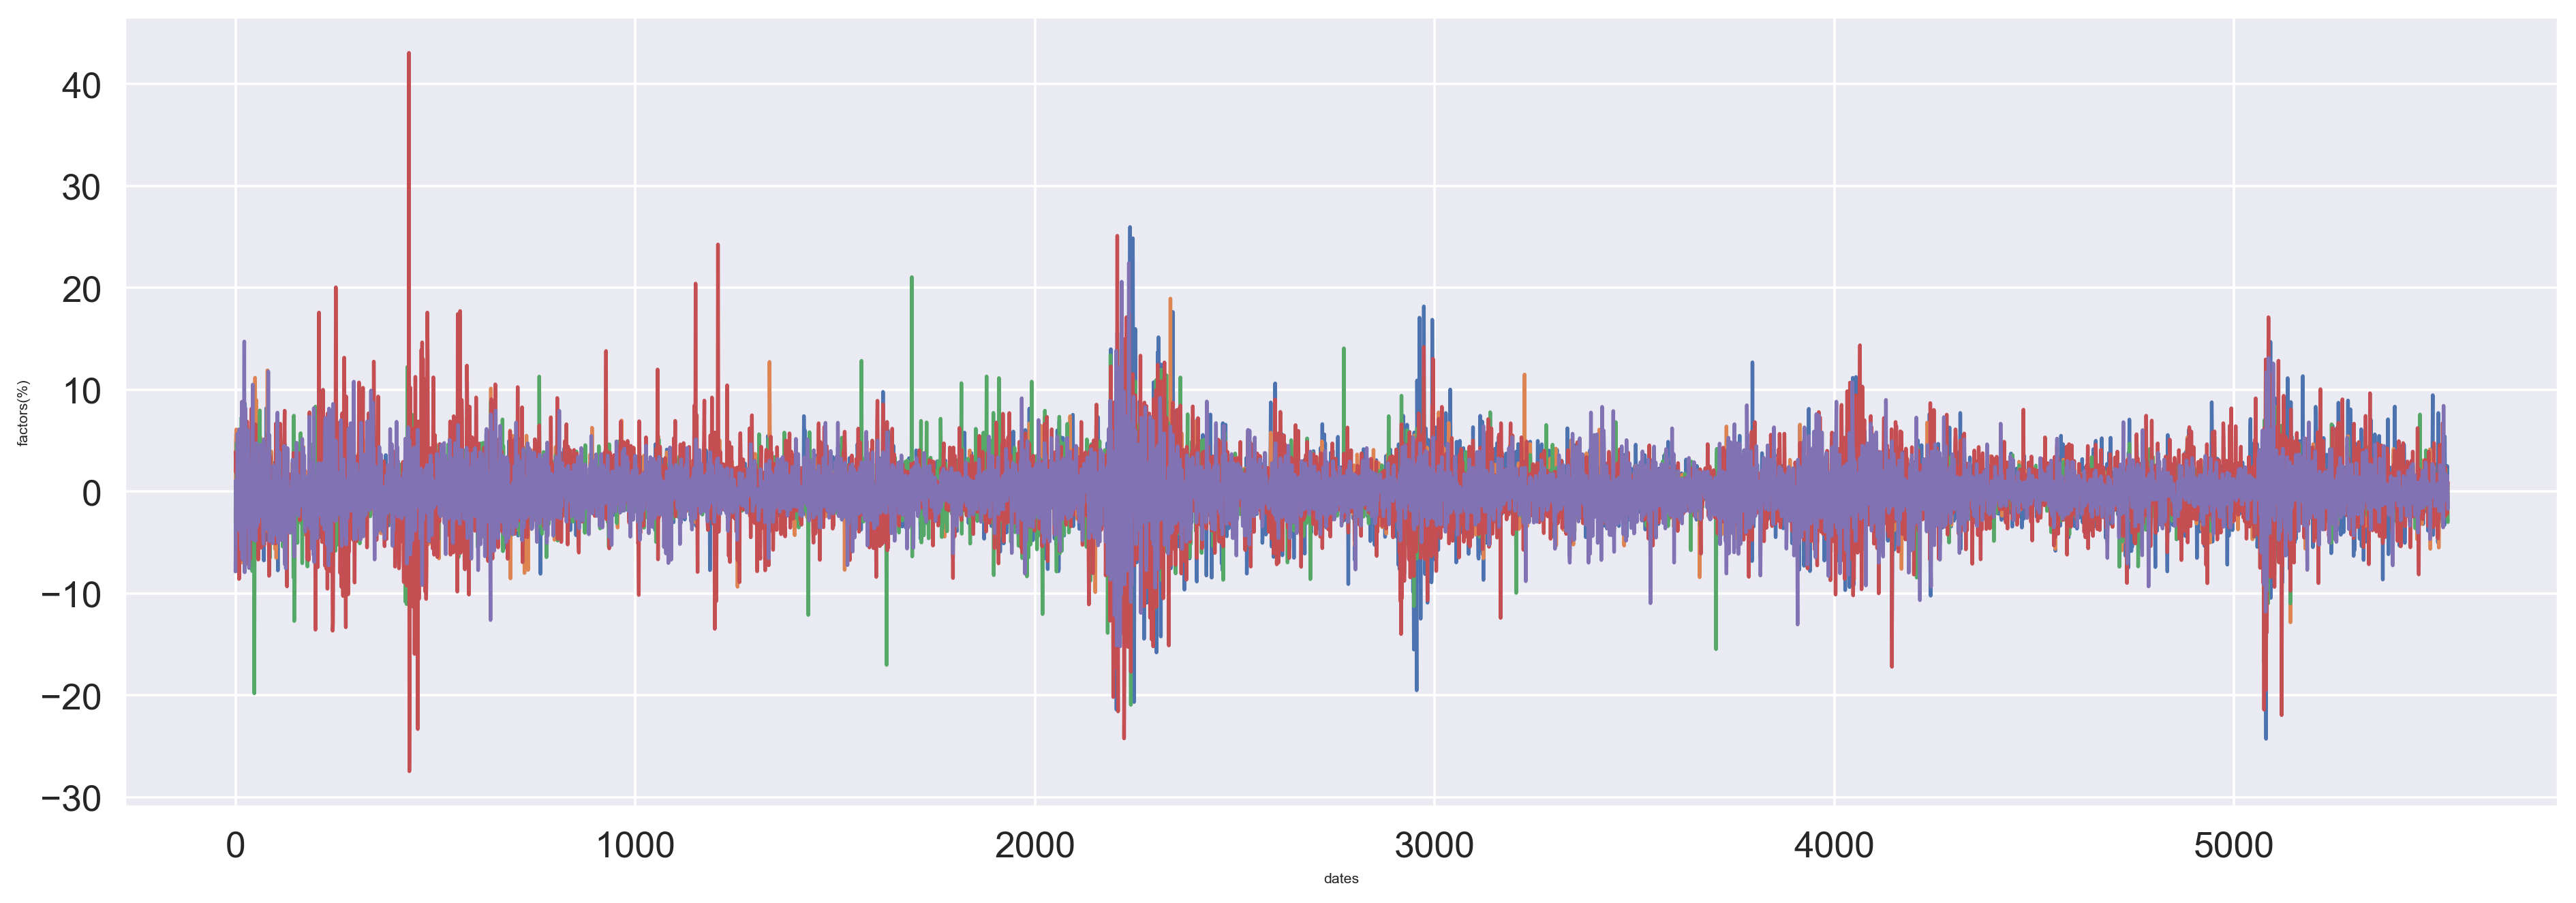

In [18]:
# plot first five PCA factors series
plt.rcParams["figure.dpi"] = 256
df_pca_factors.plot(figsize=(18, 6),legend=False)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('dates')
plt.ylabel('factors(%)')
plt.show()

In [19]:
# get first one and three factors 
X1_PCA = pca.transform(X)[:, 0]
X3_PCA = pca.transform(X)[:, 0:3]

## 4.1  extract residuals from first principle components and estimate network

In [20]:
sp100_pca1_idio = pd.DataFrame(columns=sp100.columns,index=sp100.index)
X1_PCA = X1_PCA.reshape(len(X1_PCA), 1)
for i in range(N):
    y = sp100[ sp100.columns[i] ].values
    y = y.reshape(len(y), 1)
    reg = linreg().fit( X1_PCA , y  )
    sp100_pca1_idio[ sp100_pca1_idio.columns[i] ] =  y - reg.predict(X1_PCA)
    betas[i] = abs(reg.coef_[0][0])
    
# we are going to use the GraphicalLasso routine from the sklearn package
sp100_network_pca1 = glasso(alpha=0.3).fit( sp100_pca1_idio )
# get the precision matrix
K = sp100_network_pca1.precision_
# construct the adjencency matrix
A = np.zeros( (N, N))
for i in range(N):
    for j in range(i-1):
        if abs(K[i,j]) > 0:
            A[i,j] = 1
            A[j,i] = 1

# construct partial correlations            
PC = np.zeros( (N, N) )
for i in range(N):
    for j in range(i-1):
        if abs(K[i,j]) > 0 :
            PC[i,j] = -K[i,j]/sqrt( K[i,i] * K[j,j] )

# compute the degree
degree = A.sum(axis=0) 

print('Number of connections %d '% (sum(degree)/2) )
print("Network density %2.2f%%" % ( 100*(sum(degree)/2) / (N*(N-1)/2) ) ) 

Number of connections 682 
Network density 13.78%


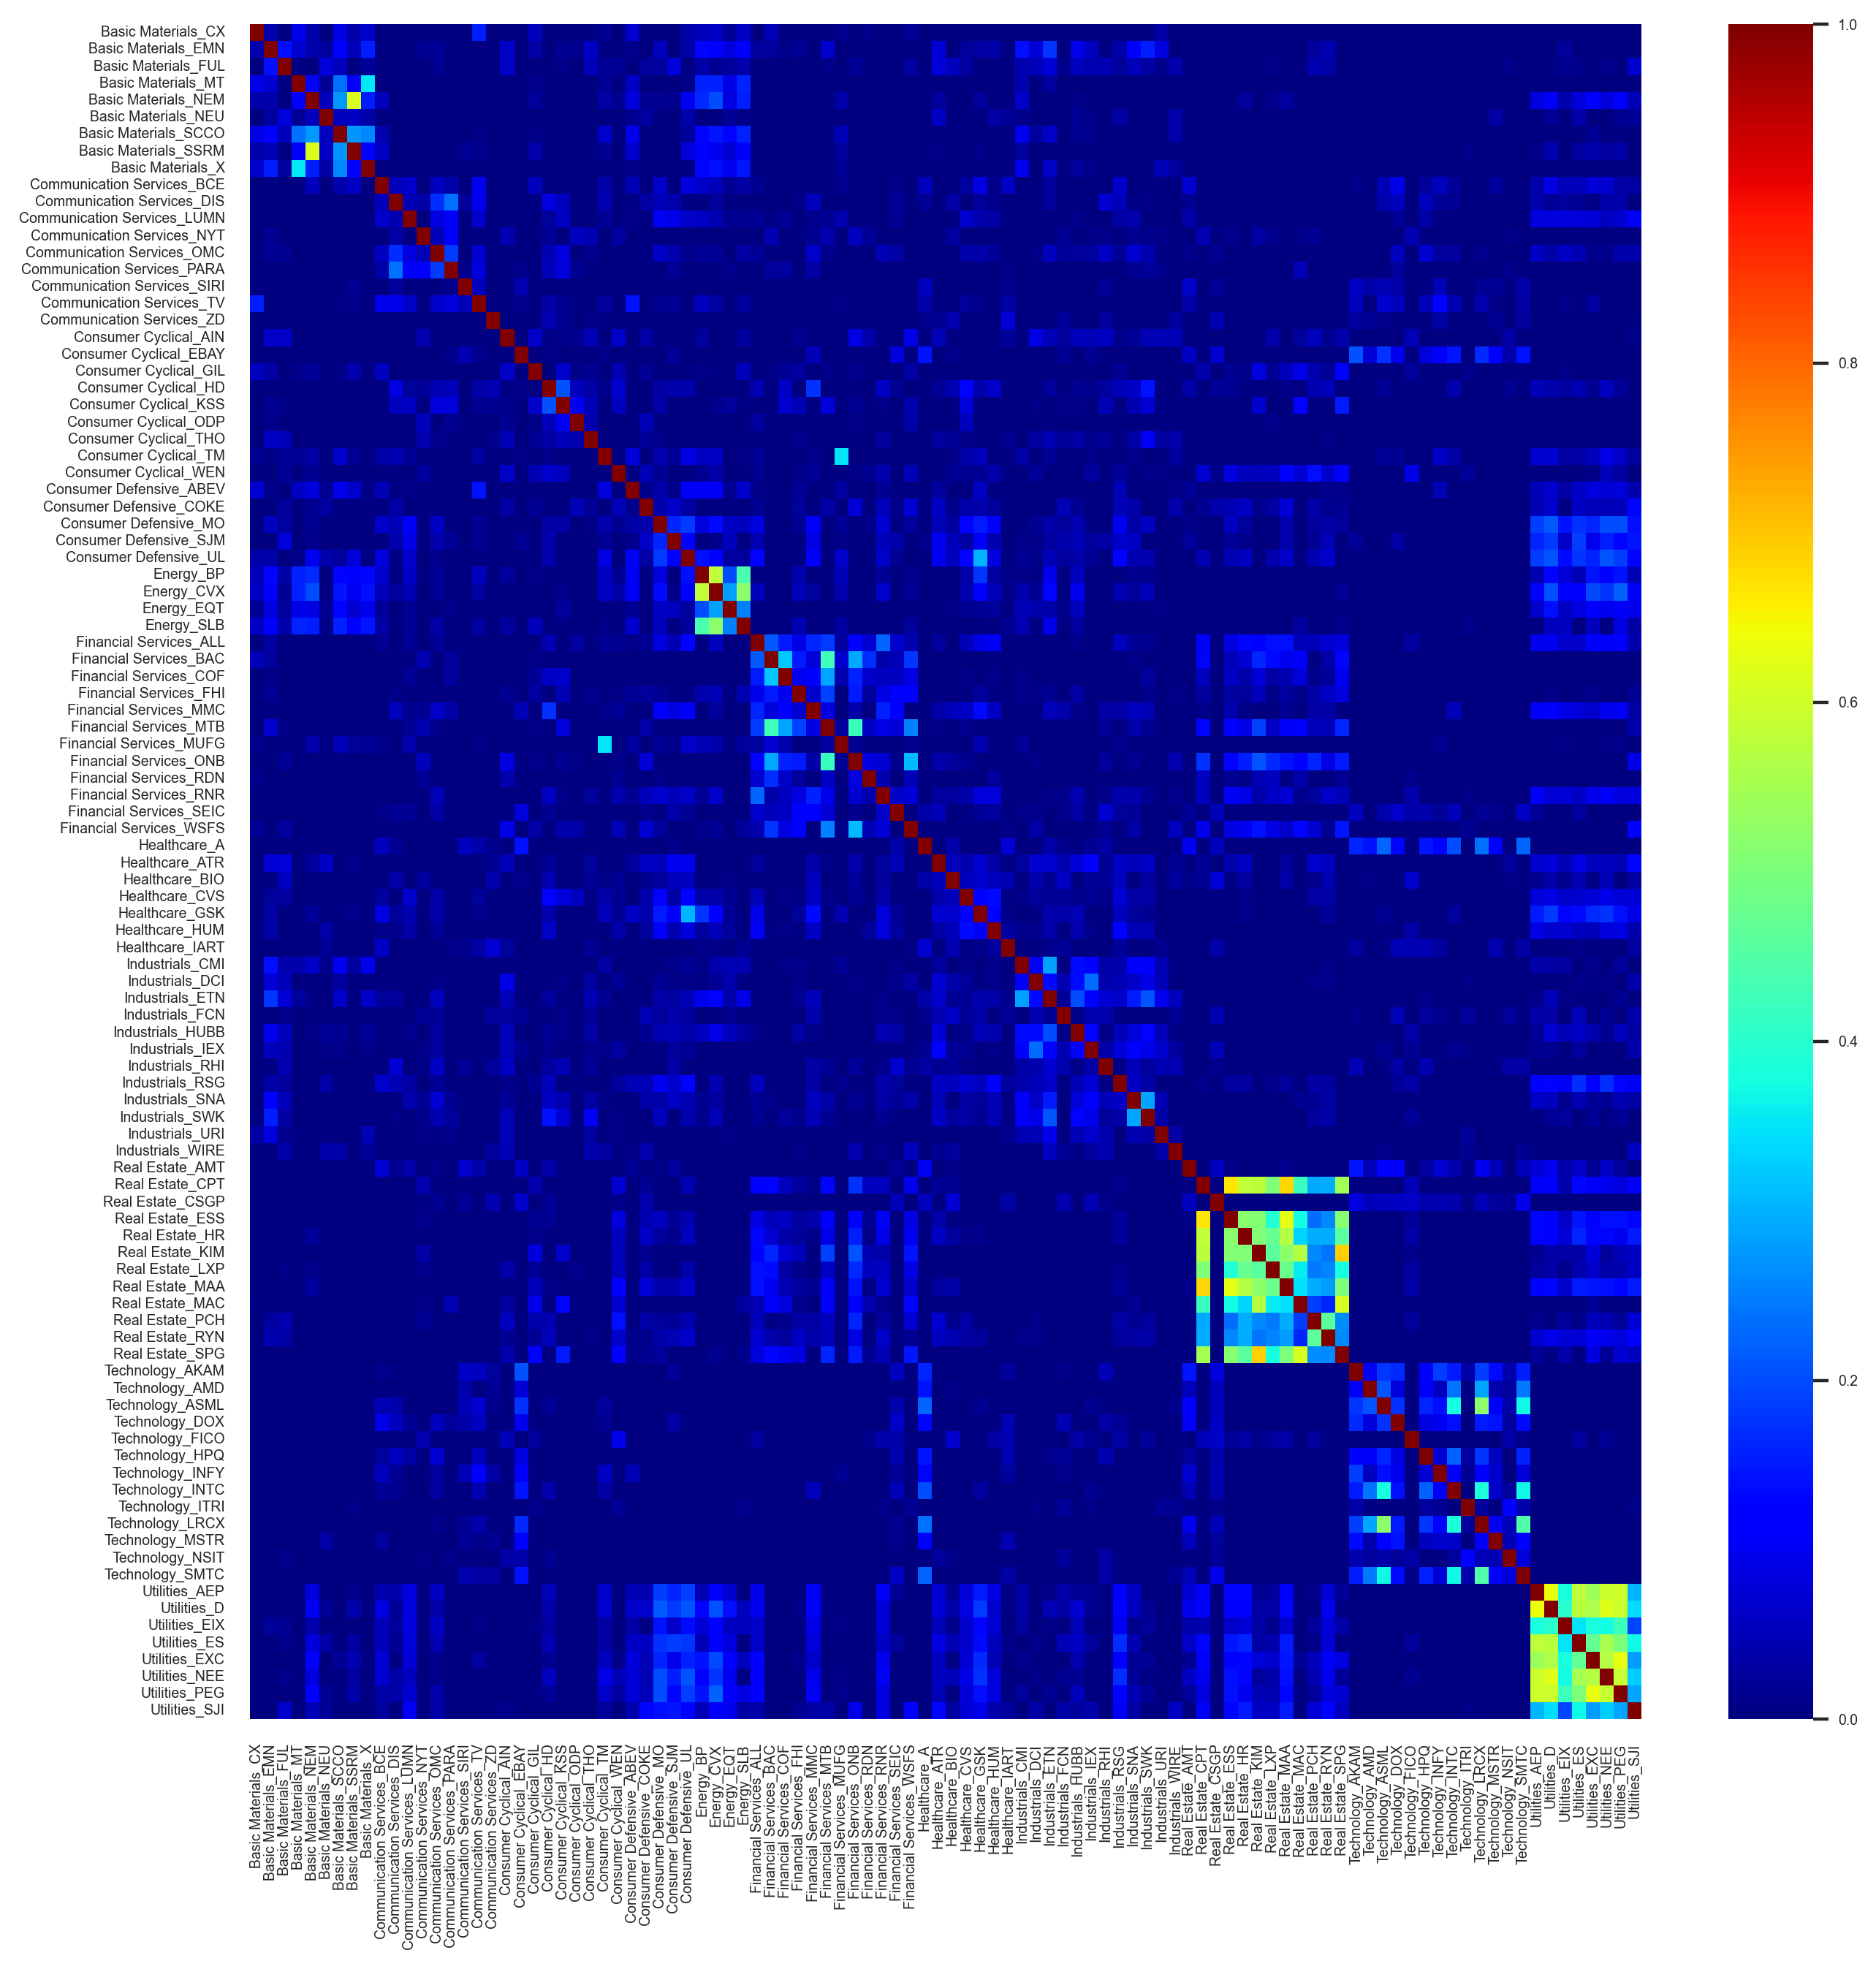

In [21]:
# heatmap of the idiosyncratic correlation 
corr_pca1 = sp100_pca1_idio.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr_pca1, xticklabels=sp100_idio.columns, vmin=0, vmax=1,
            yticklabels=sp100_idio.columns, cmap='jet')
plt.show()

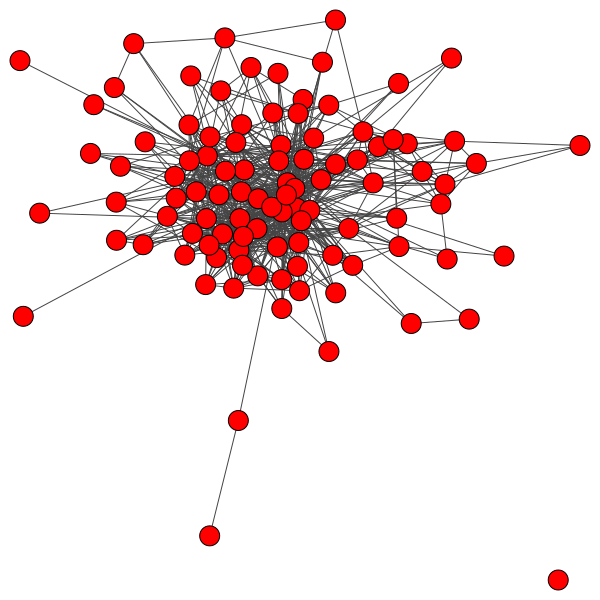

In [22]:
# create a graph object
g = ig.Graph.Adjacency( (A>0).tolist() , mode=ig.ADJ_UNDIRECTED )
ig.plot(g)

## 4.2 extract residuals from first three principle components and estimate network

In [23]:
sp100_pca3_idio = pd.DataFrame(columns=sp100.columns,index=sp100.index)
X3_PCA = X3_PCA.reshape(len(X3_PCA), 3)
for i in range(N):
    y = sp100[ sp100.columns[i] ].values
    y = y.reshape(len(y), 1)
    reg = linreg().fit( X3_PCA , y  )
    sp100_pca3_idio[ sp100_pca3_idio.columns[i] ] =  y - reg.predict(X3_PCA)
    betas[i] = abs(reg.coef_[0][0])
    
# we are going to use the GraphicalLasso routine from the sklearn package
# the data
sp100_network_pca3 = glasso(alpha=0.3).fit( sp100_pca3_idio )
# get the precision matrix
K = sp100_network_pca3.precision_
# construct the adjencency matrix
A = np.zeros((N, N))
for i in range(N):
    for j in range(i-1):
        if abs(K[i,j]) > 0:
            A[i,j] = 1
            A[j,i] = 1
# construct partial correlations            
PC = np.zeros((N, N))
for i in range(N):
    for j in range(i-1):
        if abs(K[i,j]) > 0 :
            PC[i,j] = -K[i,j]/sqrt( K[i,i] * K[j,j])

# compute the degree
degree = A.sum(axis = 0) 
print('Number of connections %d '% (sum(degree)/2) )
print("Network density %2.2f%%" % ( 100*(sum(degree)/2) / (N*(N-1)/2) ) ) 

Number of connections 400 
Network density 8.08%


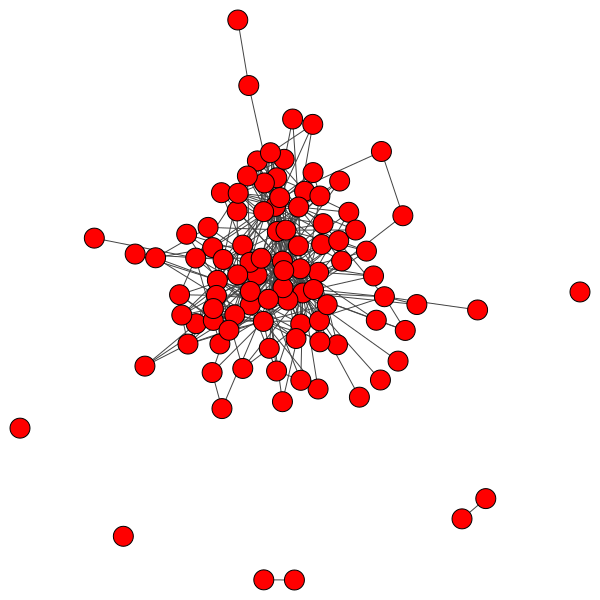

In [24]:
# create a graph object
g = ig.Graph.Adjacency( (A>0).tolist() , mode=ig.ADJ_UNDIRECTED )
ig.plot(g)

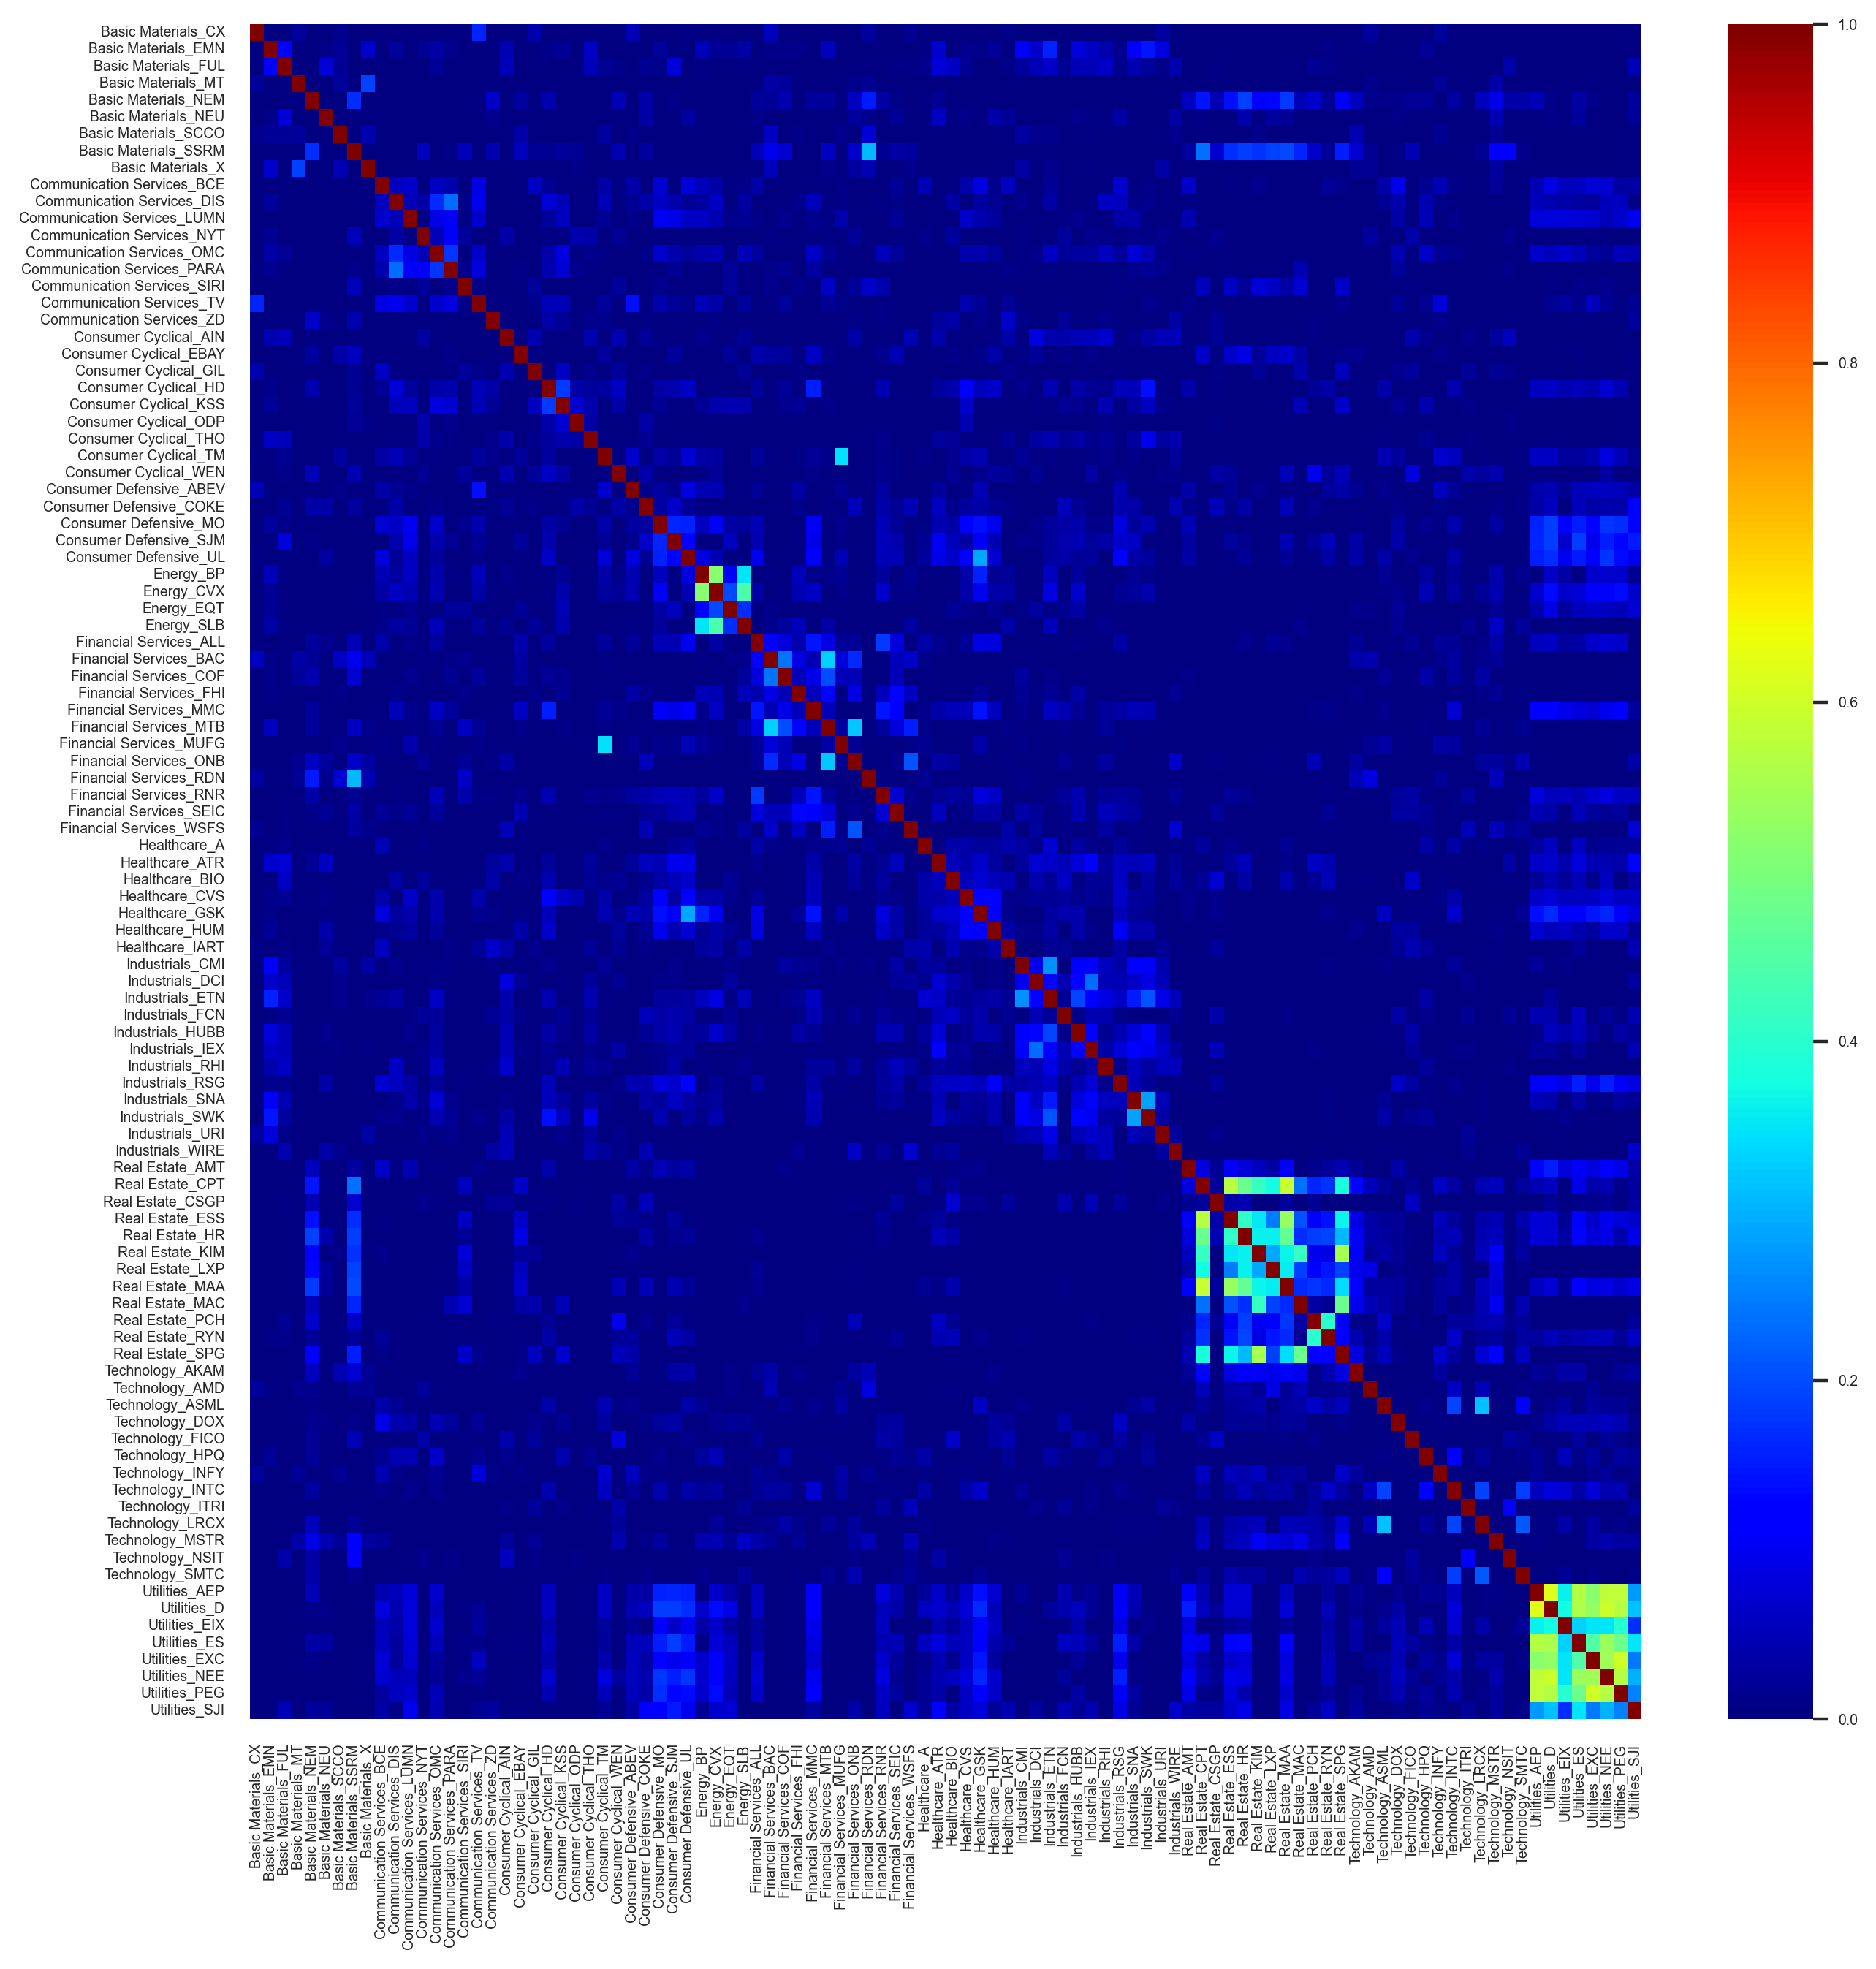

In [25]:
# heatmap of the idiosyncratic correlation 
corr_pca3 = sp100_pca3_idio.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr_pca3, xticklabels=sp100_pca3_idio.columns,
            yticklabels=sp100_pca3_idio.columns, 
            vmin=0, vmax=1,cmap='jet')
plt.show() 

## 4.3 conclusion for PCA method

We use the PCA mehtod to extract the priciple components. After we detract the first component, the density of estimated 
network density reduces significantly from 40.14% to 13.78%. After we detract the first three components, the density of estimated network reduce from 13.78%  to 8.08\%. The correlation of the residual parts also decreases obviously. So in the following precision matrix estimation we will use PCA factors.

# 5 minimum variance portflio construction

In this section, we will compare the performance of our minimum-variance portfolio. The baseline model is sample covariance. In addition, we also include sample covariance portfolio and average portfolio in our comparision. For the covariance matrix estimation, we will use 5-year(1260 days) historical data and then predcit the following one month(21 days) covariance matrix. Then finally throng the estimated covariance matrix, we will cosntruction minimum variance portfolio and compare the out-of-sample variance according to the variance of the daily return of our portfolos.

In [26]:
from cvxopt import matrix
from cvxopt.blas import dot 
from cvxopt import solvers
solvers.options['show_progress'] = False

def get_return(weights, res_pre):
    weights = np.matrix(weights)
    res_pre = np.matrix(res_pre)
    return (weights*res_pre).tolist()[0]

def network_cov(X, factor_num = 1):
    # PCA to get facctors:
    N = X.shape[1]
    Betas = np.zeros((N, factor_num))
    res = np.zeros_like(X)
    pca = PCA(n_components=5)
    pca.fit(X)
    X_PCA = pca.transform(X)[:, 0:factor_num]
    # regress to get factor loading and residuals:
    for i in range(N):
        y = X[:, i:i+1]
        reg = linreg().fit(X_PCA, y)
        res[:, i:i+1] =  y - reg.predict(X_PCA)
        Betas[i, :] = reg.coef_ 
    # estimate partial correlation:
    res_cov = glasso(alpha=0.05, mode='cd', tol=0.001).fit(res).covariance_
    # recover covariance matrix:
    factor_cov = np.reshape(np.cov(X_PCA.T), (factor_num, factor_num))
    Cov = np.matmul(np.matmul(Betas, factor_cov), Betas.T) + res_cov
    return Cov

def get_ws_cov(cov, no_short=False):
    if no_short:
        N = cov.shape[0]
        P = matrix(cov)
        q = matrix(np.zeros((N, 1)))
        G  = matrix(-np.identity(N))
        h = matrix(np.zeros((N, 1)))
        A = matrix(1.0, (1, N))
        b = matrix(1.0)
        sol = solvers.qp(P, q, G, h, A, b)
        ws = np.matrix(sol['x']).T
    else:
        cov_mat = np.matrix(cov)
        N = cov_mat.shape[0]
        I = np.matrix(np.ones(N)).T
        ws = (cov_mat.I * I)/(I.T*cov_mat.I*I)
        ws = ws.T
    return ws

def get_hold_ws(ws1, res_mat_pre):
    ws11 = np.multiply(ws1, (1+np.sum(res_mat_pre, axis=1)))
    ws11 = ws11
    return ws11.tolist()[0]

def get_rets_net(X_ret, factor_num=1):
    rets = []
    set_ws = []
    ed_idx = 0
    for i in tqdm(range(200)):
        st_idx = i*21
        ed_idx = 1260 + i*21
        res_mat_i = X_ret[st_idx:ed_idx, :]
        cov_i = network_cov(res_mat_i, factor_num = factor_num)
        cov_i[cov_i<0.0000001] = 0
        ws_i = get_ws_cov(cov_i, no_short=False)
        st_idx_next = ed_idx+1 
        ed_idx_next = ed_idx+22
        ret_next_i = X_ret[st_idx_next:ed_idx_next, :]
        ret_next_i = np.matrix(ret_next_i).T
        ret_i = get_return(ws_i, ret_next_i)
        set_ws.append(ws_i.tolist()[0])
        rets += ret_i
    return rets

def get_rets_sample(X_ret):
    rets = []
    set_ws = []
    ed_idx = 0
    for i in tqdm(range(200)):
        st_idx = i*21
        ed_idx = 1260 + i*21
        res_mat_i = X_ret[st_idx:ed_idx, :]
        cov_i = np.cov(res_mat_i.T)
        ws_i = get_ws_cov(cov_i, no_short=False)
        st_idx_next = ed_idx+1 
        ed_idx_next = ed_idx+22
        ret_next_i = X_ret[st_idx_next:ed_idx_next, :]
        ret_next_i = np.matrix(ret_next_i).T
        ret_i = get_return(ws_i, ret_next_i)
        set_ws.append(ws_i.tolist()[0])
        rets += ret_i
    return rets

def net_values(ret):
    x0 = 1
    values = [x0]
    for i in ret:
        x0 = x0*(1+i/100)
        values.append(x0)
    return values

In [27]:
# 1 construct portfolio from sample covariance matrix
rets_sam = get_rets_sample(X)
# 2 construct portfolio from  covariance matrix estimated by First PCA factor
rets_net = get_rets_net(X)
# 3 construct portfolio from  covariance matrix estimated by First three PCA factors
rets_net3 = get_rets_net(X, factor_num=3)

100%|█████████████████████████████████████████| 200/200 [00:28<00:00,  7.12it/s]


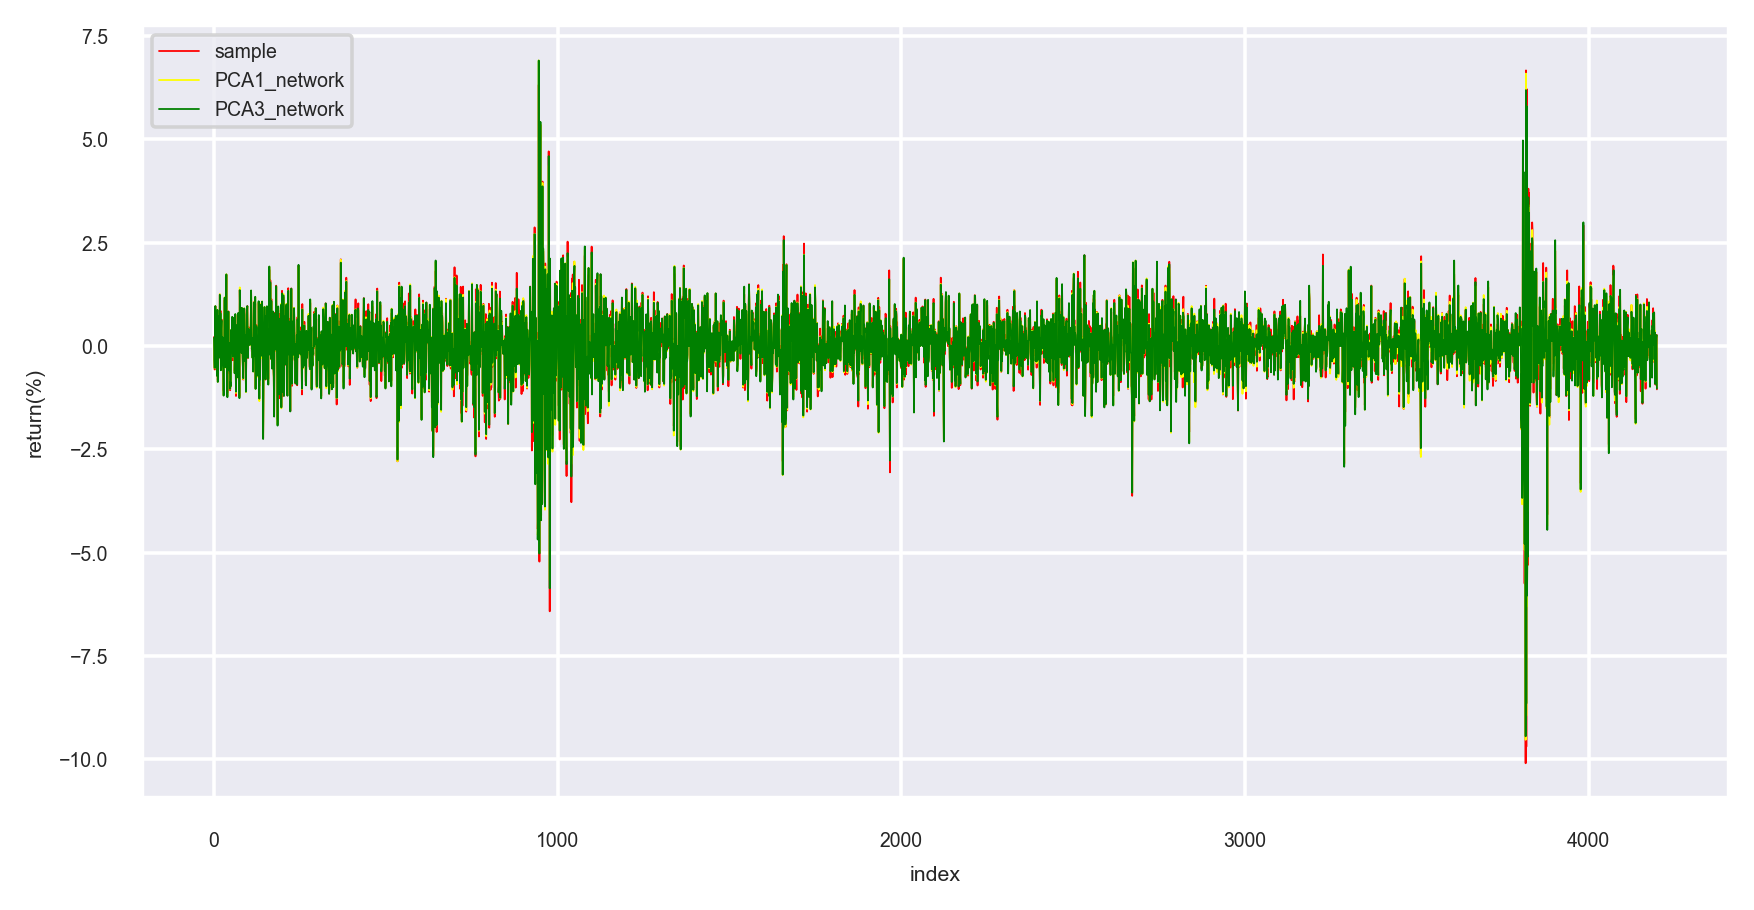

In [28]:
# plot daily return 
plt.figure(figsize=(8, 4))
plt.rcParams["figure.dpi"] = 256
plt.plot(rets_sam, color='red',  label='sample', linewidth=0.5)
plt.plot(rets_net, color='yellow', label='PCA1_network', linewidth=0.5)
plt.plot(rets_net3, color='green', label='PCA3_network', linewidth=0.5)
plt.xlabel('index')
plt.ylabel('return(%)')
plt.legend()

In [29]:
# get indicators for portfolios:
from scipy import stats
indicators = np.zeros((3,4))
d = 252
d2 = 252**0.5 
indicators[0, :] = [np.mean(rets_sam)*d, np.std(rets_sam)*d2, np.mean(rets_sam)*d2/np.std(rets_sam), 1]
indicators[1, :] = [np.mean(rets_net)*d, np.std(rets_net)*d2, np.mean(rets_net)*d2/np.std(rets_net), stats.ttest_ind(rets_sam*d,rets_net*d)[1]]
indicators[2, :] = [np.mean(rets_net3)*d, np.std(rets_net3)*d2, np.mean(rets_net3)*d2/np.std(rets_net3), stats.ttest_ind(rets_sam*d,rets_net3*d)[1]]
df_indicators  = pd.DataFrame(indicators, columns=['mean', 'std', 'sharp_ratio', 'significant difference'])
df_indicators['estimator'] = ['sample', 'PCA1_network', 'PCA3_network']
df_indicators

mean        std  sharp_ratio  significant difference     estimator
0  8.194586  13.379137     0.612490                1.000000        sample
1  8.845999  13.179566     0.671190                0.024583  PCA1_network
2  8.929615  13.172730     0.677886                0.011178  PCA3_network

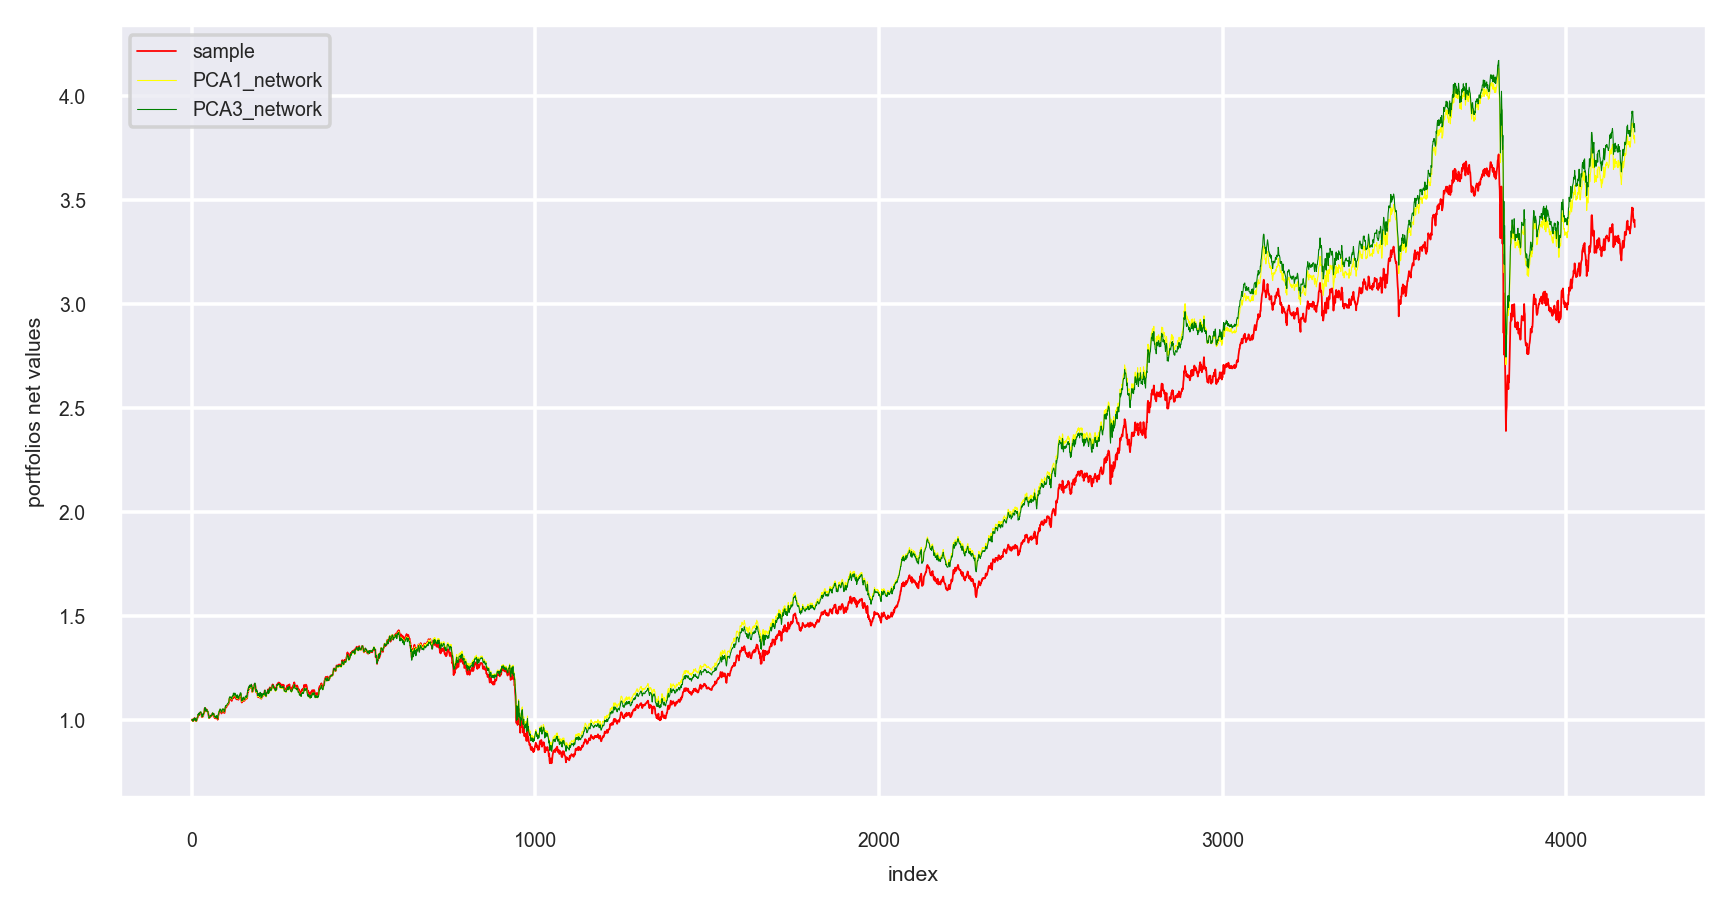

In [30]:
# plot net values of portfolios
plt.figure(figsize=(8, 4))
plt.rcParams["figure.dpi"] = 256
values_sam = net_values(rets_sam)
values_net = net_values(rets_net)
values_net3 = net_values(rets_net3)
plt.plot(values_sam, color='red',  label='sample', linewidth=0.5)
plt.plot(values_net, color='yellow', label='PCA1_network', linewidth=0.3)
plt.plot(values_net3, color='green', label='PCA3_network', linewidth=0.3)
plt.xlabel('index')
plt.ylabel('portfolios net values')
plt.legend()

## Conclusion:

Seeing from the table, the networks estimators are slightly better than the sample covariance and the difference is 5% significant. But If we increase the number of assets, the difference will become more signifcant. In additon, the difference of the one-latent factor model and three-latent factor model is modest.

# 6  Dynamics of network in in-crisis, post-crisis,  pre-crisis periods

In [78]:
sp100_pre = sp100_date[(sp100_date['date']>'2005-01-01') & (sp100_date['date']<'2007-01-01')]
sp100_pre = sp100_pre.drop('date', axis=1)
sp100_in  = sp100_date[(sp100_date['date']>'2007-12-01') & (sp100_date['date']<'2008-12-01')]
sp100_in = sp100_in.drop('date', axis=1)
sp100_post  = sp100_date[(sp100_date['date']>'2010-01-01') & (sp100_date['date']<'2012-01-01')]
sp100_post = sp100_post.drop('date', axis=1)

## 6.1 pre-crisis

In [89]:
X_pre = sp100_pre.to_numpy()
pca = PCA(n_components=10)
pca.fit(X_pre)
# get first one and three factors 
Xpre_PCA = pca.transform(X_pre)[:, 0]

sp100_pre_idio = pd.DataFrame(columns=sp100_pre.columns,index=sp100_pre.index)
Xpre_PCA = Xpre_PCA.reshape(len(Xpre_PCA), 1)
for i in range(N):
    y = sp100_pre[sp100_pre.columns[i]].values
    y = y.reshape(len(y), 1)
    reg = linreg().fit( Xpre_PCA , y)
    sp100_pre_idio[sp100_pca1_idio.columns[i] ] =  y - reg.predict(Xpre_PCA)

Number of connections 298 
Network density 6.02%


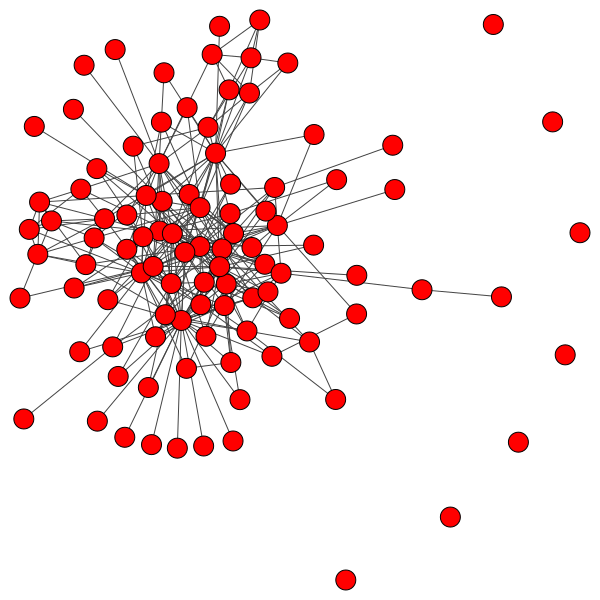

In [104]:
sp100_network_pre = glasso(alpha=0.3).fit( sp100_pre_idio)
# get the precision matrix
K = sp100_network_pre.precision_
# construct the adjencency matrix
A = np.zeros((N, N))
for i in range(N):
    for j in range(i-1):
        if abs(K[i,j]) > 0:
            A[i,j] = 1
            A[j,i] = 1
# construct partial correlations            
PC = np.zeros((N, N))
for i in range(N):
    for j in range(i-1):
        if abs(K[i,j]) > 0 :
            PC[i,j] = -K[i,j]/sqrt( K[i,i] * K[j,j])

# compute the degree
degree = A.sum(axis = 0) 
print('Number of connections %d '% (sum(degree)/2) )
print("Network density %2.2f%%" % ( 100*(sum(degree)/2) / (N*(N-1)/2))) 
# create a graph object
g = ig.Graph.Adjacency( (A>0).tolist() , mode=ig.ADJ_UNDIRECTED )
ig.plot(g)

## 6.2 in-crisis

In [91]:
X_in = sp100_in.to_numpy()
pca = PCA(n_components=10)
pca.fit(X_in)
# get first one and three factors 
Xin_PCA = pca.transform(X_in)[:, 0]

sp100_in_idio = pd.DataFrame(columns=sp100_in.columns, index=sp100_in.index)
Xin_PCA = Xin_PCA.reshape(len(Xin_PCA), 1)
for i in range(N):
    y = sp100_in[sp100_in.columns[i]].values
    y = y.reshape(len(y), 1)
    reg = linreg().fit( Xin_PCA , y)
    sp100_in_idio[sp100_in_idio.columns[i]] =  y - reg.predict(Xin_PCA)

Number of connections 2125 
Network density 42.93%


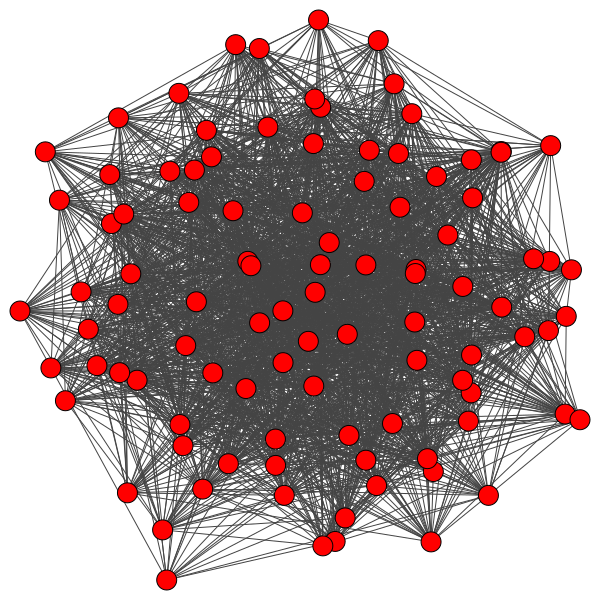

In [103]:
sp100_network_in = glasso(alpha=0.3).fit( sp100_in_idio)
# get the precision matrix
K = sp100_network_in.precision_
# construct the adjencency matrix
A = np.zeros((N, N))
for i in range(N):
    for j in range(i-1):
        if abs(K[i,j]) > 0:
            A[i,j] = 1
            A[j,i] = 1
# construct partial correlations            
PC = np.zeros((N, N))
for i in range(N):
    for j in range(i-1):
        if abs(K[i,j]) > 0 :
            PC[i,j] = -K[i,j]/sqrt( K[i,i] * K[j,j])

# compute the degree
degree = A.sum(axis = 0) 
print('Number of connections %d '% (sum(degree)/2) )
print("Network density %2.2f%%" % ( 100*(sum(degree)/2) / (N*(N-1)/2))) 
# create a graph object
g = ig.Graph.Adjacency( (A>0).tolist() , mode=ig.ADJ_UNDIRECTED )
ig.plot(g)

## 6.3 post-crisis

In [93]:
X_post = sp100_post.to_numpy()
pca = PCA(n_components=10)
pca.fit(X_post)
# get first one and three factors 
Xpost_PCA = pca.transform(X_post)[:, 0]

sp100_post_idio = pd.DataFrame(columns=sp100_post.columns, index=sp100_post.index)
Xpost_PCA = Xpost_PCA.reshape(len(Xpost_PCA), 1)
for i in range(N):
    y = sp100_post[sp100_post.columns[i]].values
    y = y.reshape(len(y), 1)
    reg = linreg().fit( Xpost_PCA , y)
    sp100_post_idio[sp100_post_idio.columns[i]] =  y - reg.predict(Xpost_PCA)

Number of connections 345 
Network density 6.97%


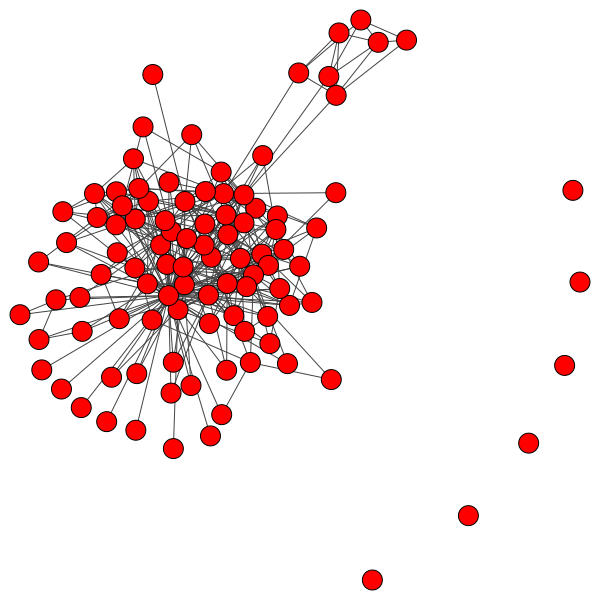

In [102]:
sp100_network_post = glasso(alpha=0.3).fit(sp100_post_idio)
# get the precision matrix
K = sp100_network_post.precision_
# construct the adjencency matrix
A = np.zeros((N, N))
for i in range(N):
    for j in range(i-1):
        if abs(K[i,j]) > 0:
            A[i,j] = 1
            A[j,i] = 1
# construct partial correlations            
PC = np.zeros((N, N))
for i in range(N):
    for j in range(i-1):
        if abs(K[i,j]) > 0 :
            PC[i,j] = -K[i,j]/sqrt( K[i,i] * K[j,j])

# compute the degree
degree = A.sum(axis = 0) 
print('Number of connections %d '% (sum(degree)/2) )
print("Network density %2.2f%%" % ( 100*(sum(degree)/2) / (N*(N-1)/2))) 
# create a graph object
g = ig.Graph.Adjacency( (A>0).tolist() , mode=ig.ADJ_UNDIRECTED )
ig.plot(g)


## 6.4 conclision1

We empirically show that within a ﬁnancial network, indirect links are strengthened during systemic events. That means in bad time, the connections between the different stocks are very strong while the connections between the different stocks are much weaker in boom periods. 